# Durchführung eines Diagnose- und Predicitve Maintenance-Projekts (Lea Sagemüller, Enzo Zacharias)

Im Rahmen des Wahlmoduls Diagnose und Predictive Maintenance im fünften Semester des Studiengangs Digitale Technologien wurde als Modulprüfung eine Hausarbeit verfasst, die ein Projekt im Diagnose- und Predictive Maintenance-Bereich beinhaltet. Aus den behandelten Kapiteln der Lehrveranstaltung sollten jeweils Inhalte aufgegriffen werden und auf einen ausgewählten Datensatz angewendet werden. Der Ablauf des Projektes unterteilt sich in die Datenbeschreibung, die Datenvorverarbeitung, die Anomalieerkennung, Predicitve Maintenance sowie die Diagnose und Fehlerursachenerkennung. 

## Auswahl des Datensatzes

Für die Durchführung des Projektes wird ein passender Datensatz ausgewählt, an welchem die oben genannten Schritte durchgeführt werden. Der Microsoft Azure Predictive Maintenance-Datensatz auf Kaggle bietet dafür eine umfassende Grundlage. Es handelt sich dabei um einen synthetischen Datensatz, der auf Basis von realitätsnahen Szenarien erstellt wurde. Er umfasst verschiedene Datenquellen, darunter Sensordaten, Fehlerprotokolle, Wartungsinformationen sowie Maschinendaten. Ziel des Datensatzes ist es, Muster und Zusammenhänge zu erkennen, die dabei helfen, Ausfälle frühzeitig vorherzusagen und die Wartungsplanung zu optimieren. Die Daten erhalten zeitlich gestempelte Sensormessungen, die den Zustand und Betrieb von Maschinen überwachen, beispielsweise Temperatur- oder Druckwerte. Ergänzend dazu dokumentieren Fehlerprotokolle aufgetretene Störungen, während Wartungslogs Informationen über geplante oder ungeplante Instandhaltungsmaßnahmen bereitstellen. Stammdaten zu den Maschinen, wie Modelltyp oder Alter, sowie Details zu tatsächlichen Ausfällen, einschließlich Ausfalltyp und Zeitstempel, sind ebenfalls Teil des Datensatzes.

## Einlesen der Datensätze und Zusammenführung

### Notwendige Imports

In [1]:
# Systembibliothek
import os

# Datenmanipulation und Analyse
import pandas as pd
import numpy as np

# Datenvisualisierung
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from scipy.stats import gaussian_kde

# Maschinelles Lernen: Modelle und Vorverarbeitung
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
import anai

# Deep Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Sampling und Resampling
from imblearn.over_sampling import SMOTE

# Self-Organizing Maps (SOM)
from minisom import MiniSom

# Joblib für das Speichern und Laden von Modellen
import joblib

# Utility für die Anzeige von DataFrames im Jupyter Notebook
from IPython.display import display


2024-12-09 12:46:07,105 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-a6verhhi', purging
2024-12-09 12:46:07,105 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-lsadfcdv', purging
2024-12-09 12:46:10.316653: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 12:46:10.350964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 12:46:10.352163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 12:46:11.003211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Es werden verschiedene Python-Bibliotheken für Datenanalyse, -visualisierung und maschinelles Lernen genutzt. Dazu gehören Werkzeuge für Datenmanipulation (z. B. Pandas, NumPy), Modelltraining (z. B. Scikit-Learn, TensorFlow) und Visualisierung (z. B. Matplotlib, Seaborn), um komplexe Datensätze zu analysieren, Modelle zu trainieren und Ergebnisse übersichtlich darzustellen.

### Import der Haupttabelle

In [2]:
# Liest die CSV-Datei 'PdM_telemetry.csv' aus dem angegebenen Verzeichnis und speichert sie in einem DataFrame
df = pd.read_csv(r'data/PdM_telemetry.csv')

# Gibt die ersten fünf Zeilen des DataFrames aus, um einen Überblick über die Daten zu erhalten
df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Zunächst wird die Haupttabelle "PdM_telemetry.csv" importiert, im Folgenden die vier zusätzlichen Tabellen.

### Zusatz-Tabellen importieren

In [3]:
# Importiert pandas und liest die CSV-Dateien in DataFrames ein
import pandas as pd
df_errors = pd.read_csv(r'data/PdM_errors.csv')
df_failures = pd.read_csv(r'data/PdM_failures.csv')
df_maint = pd.read_csv(r'data/PdM_maint.csv')
df_machines = pd.read_csv(r'data/PdM_machines.csv')

### Ausgabe der einzelnen Datensätze

Nun werden jeweils die ersten fünf Einträge aus den erstellten Dataframes der einzelnen Datensätze ausgegeben.

In [4]:
# Gibt die ersten fünf Zeilen des 'df_errors' DataFrames aus
df_errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [5]:
# Gibt die ersten fünf Zeilen des 'df_failures' DataFrames aus
df_failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [6]:
# Gibt die ersten fünf Zeilen des 'df_maint' DataFrames aus
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [7]:
# Gibt die ersten fünf Zeilen des 'df_machines' DataFrames aus
df_machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


Hier weiß ich nicht mehr, was genau der Plan war:

Hier könnte man diese Tabelle exemplarisch als Beispiel aufzeigen --> Danach zusammenführen in einem Dataframe in Bezug auf machineID und datetime

In [8]:
# Definiert den Dateipfad und die Dateinamen
directory = r'data'
files = [r'PdM_errors.csv', r'PdM_failures.csv', r'PdM_machines.csv', r'PdM_maint.csv', r'PdM_telemetry.csv']

# Erstellt ein Dictionary zum Speichern der DataFrames
dfs = {}
for file in files:
    filepath = os.path.join(directory, file)  # Ermittelt den vollständigen Dateipfad
    df_name = file.split('.')[0]  # Extrahiert den Namen der Datei ohne Erweiterung
    dfs[df_name] = pd.read_csv(filepath)  # Liest die CSV-Datei und speichert sie im Dictionary

# Führt die DataFrames anhand der gemeinsamen Spalten zusammen
merged_df = dfs['PdM_telemetry']
merged_df = merged_df.merge(dfs['PdM_errors'], on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(dfs['PdM_failures'], on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(dfs['PdM_maint'], on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(dfs['PdM_machines'], on=['machineID'], how='left')

# Speichert das zusammengeführte DataFrame als CSV-Datei
df = merged_df
merged_df.to_csv(r'data/merged_df.csv', index=False)

Es können nun die einzelnen Dataframes zu einem gemeinsamen Dataframe in Bezug auf die Spalten "datetime" und "machineID" zusammengeführt werden.

## Datenbeschreibung

Im Folgenden wird der im CSV-Format vorliegende zusammengeführte Datensatz importiert und in einen Dataframe eingelesen. Ebenfalls in einen Dataframe eingelesen wird der Datensatz, der die Fehlerinformationen enthält. 

### Anschauen der Daten

In [9]:
# Gibt die ersten fünf Zeilen des zusammengeführten DataFrames 'df' aus
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,NaN,NaN,NaN,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,NaN,NaN,NaN,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,NaN,NaN,NaN,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,NaN,NaN,NaN,model3,18


Es werden die ersten fünf Einträge des eingelesenen Datensatzes angezeigt, um mehr über die Struktur der Daten zu erfahren.

In [10]:
# Gibt eine statistische Zusammenfassung der numerischen Spalten des DataFrames 'df' aus
df.describe()

,machineID,volt,rotate,pressure,vibration,age
count,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000
mean,50.498446,170.780942,446.570735,100.861433,40.386459,11.330280
std,28.866697,15.511268,52.698963,11.052195,5.371894,5.827535
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,25.000000,160.305918,412.265479,93.499116,36.777911,7.000000
50%,50.000000,170.609301,447.537538,100.426820,40.238339,12.000000
75%,75.000000,181.008303,482.157025,107.557338,43.786484,16.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000


Die Beschreibung der Daten ist hilfreich, um Informationen wie Minimal- und Maximalwert sowie Mittelwert oder Standardabweichung zu untersuchen und dort ggf. schon erste Auffälligkeiten erkennen zu können.

In [11]:
# Gibt Informationen über den DataFrame 'df' aus, einschließlich der Anzahl der Nicht-Null-Werte und der Datentypen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877209 entries, 0 to 877208
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   877209 non-null  object 
 1   machineID  877209 non-null  int64  
 2   volt       877209 non-null  float64
 3   rotate     877209 non-null  float64
 4   pressure   877209 non-null  float64
 5   vibration  877209 non-null  float64
 6   errorID    3924 non-null    object 
 7   failure    1122 non-null    object 
 8   comp       2968 non-null    object 
 9   model      877209 non-null  object 
 10  age        877209 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 73.6+ MB


Es werden nun die einzelnen Spalten mit ihren zugehörigen Datentypen angezeigt. Dabei fällt direkt auf, dass die Spalte "datetime" nicht im richtigen Format vorliegt und im weiteren Verlauf angepasst werden muss.

### Plotten aller Messwerte (pro Tag / pro Monat)

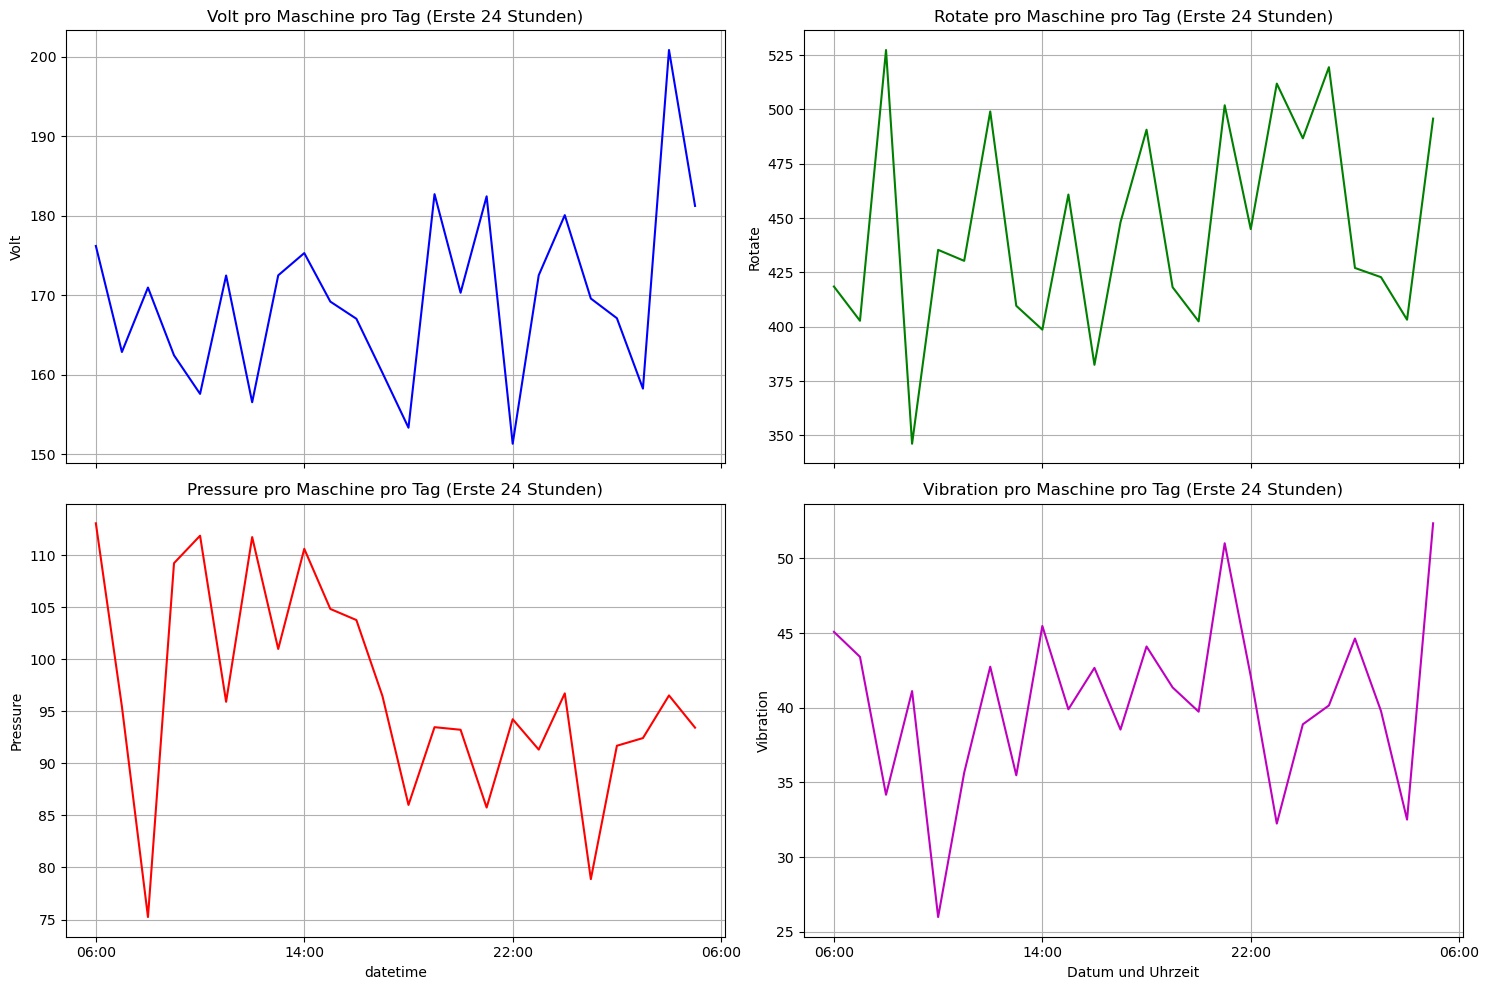

In [12]:
# Definiert das Datumsformat für die x-Achse als Stunden und Minuten
date_format = DateFormatter("%H:%M")

# Filtert die Daten für den Zeitraum der ersten 24 Stunden und für 'machineID' gleich 1
df_filtered = df[(df['datetime'] >= '2015-01-01 06:00:00') & (df['datetime'] < '2015-01-02 06:00:00') & (df['machineID'] == 1)]
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])  # Konvertiert die 'datetime'-Spalte in datetime-Objekte

# Erstellt ein 2x2 Subplot mit einer Gesamtgröße von 15x10 Zoll und geteilter x-Achse
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Plot für Spannung (volt) auf dem ersten Subplot
sns.lineplot(x='datetime', y='volt', data=df_filtered, ax=axs[0, 0], color='b')
axs[0, 0].set_title('Volt pro Maschine pro Tag (Erste 24 Stunden)')
axs[0, 0].set_ylabel('Volt')
axs[0, 0].grid(True)

# Plot für Drehzahl (rotate) auf dem zweiten Subplot
sns.lineplot(x='datetime', y='rotate', data=df_filtered, ax=axs[0, 1], color='g')
axs[0, 1].set_title('Rotate pro Maschine pro Tag (Erste 24 Stunden)')
axs[0, 1].set_ylabel('Rotate')
axs[0, 1].grid(True)

# Plot für Druck (pressure) auf dem dritten Subplot
sns.lineplot(x='datetime', y='pressure', data=df_filtered, ax=axs[1, 0], color='r')
axs[1, 0].set_title('Pressure pro Maschine pro Tag (Erste 24 Stunden)')
axs[1, 0].set_ylabel('Pressure')
axs[1, 0].grid(True)

# Plot für Vibration (vibration) auf dem vierten Subplot
sns.lineplot(x='datetime', y='vibration', data=df_filtered, ax=axs[1, 1], color='m')
axs[1, 1].set_title('Vibration pro Maschine pro Tag (Erste 24 Stunden)')
axs[1, 1].set_ylabel('Vibration')
axs[1, 1].set_xlabel('Datum und Uhrzeit')
axs[1, 1].grid(True)

# Formatieren der x-Achse, um nur Stunden und Minuten anzuzeigen und xticks zu setzen
for ax in axs.flat:
    ax.xaxis.set_major_formatter(date_format)
    xticks = pd.date_range(start='2015-01-01 06:00:00', end='2015-01-02 06:00:00', periods=4)  # Erzeugt 4 xticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks.strftime('%H:%M'))

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()
plt.show()

In diesem Code werden für die erste Maschine ("machineID" = 1) die Messdaten für Spannung (Voltage), Drehzahl (Rotate), Druck (Pressure) und Vibration in separaten Diagrammen visualisiert. Die Daten werden auf einen Zeitraum von 24 Stunden (vom 1. Januar 2015, 06:00 Uhr bis zum 2. Januar 2015, 06:00 Uhr) gefiltert. Dabei zeigt die x-Achse nur den Zeitstempel, formatiert als Uhrzeit (Stunden:Minuten), da nur auf 24 Stunden gefiltert wurde. 

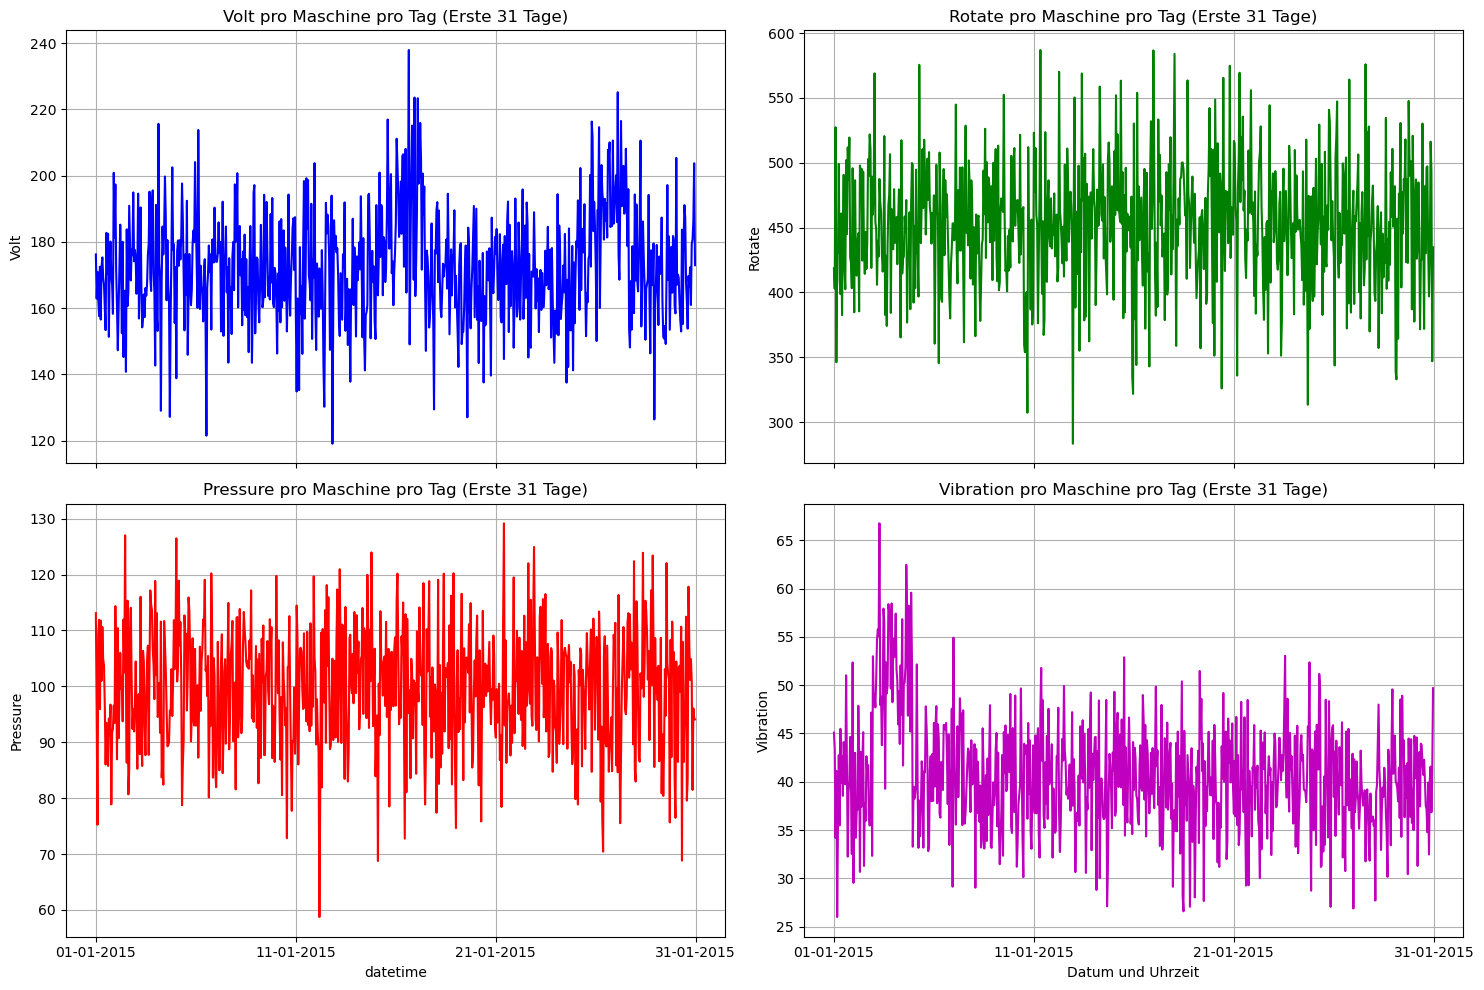

In [13]:
# Importiert den DateFormatter von matplotlib, um das Datumsformat für die x-Achse festzulegen
from matplotlib.dates import DateFormatter

# Definiert das Datumsformat als Tag-Monat-Jahr
date_format = DateFormatter("%d-%m-%Y")

# Filtert die Daten für den Zeitraum der ersten 31 Tage und für 'machineID' gleich 1
df_filtered = df[(df['datetime'] >= '2015-01-01 06:00:00') & (df['datetime'] < '2015-01-31 23:59:00') & (df['machineID'] == 1)]
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])  # Konvertiert die 'datetime'-Spalte in datetime-Objekte

# Erstellt ein 2x2 Subplot mit einer Gesamtgröße von 15x10 Zoll und geteilter x-Achse
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Plot für Spannung (volt) auf dem ersten Subplot
sns.lineplot(x='datetime', y='volt', data=df_filtered, ax=axs[0, 0], color='b')
axs[0, 0].set_title('Volt pro Maschine pro Tag (Erste 31 Tage)')
axs[0, 0].set_ylabel('Volt')
axs[0, 0].grid(True)

# Plot für Drehzahl (rotate) auf dem zweiten Subplot
sns.lineplot(x='datetime', y='rotate', data=df_filtered, ax=axs[0, 1], color='g')
axs[0, 1].set_title('Rotate pro Maschine pro Tag (Erste 31 Tage)')
axs[0, 1].set_ylabel('Rotate')
axs[0, 1].grid(True)

# Plot für Druck (pressure) auf dem dritten Subplot
sns.lineplot(x='datetime', y='pressure', data=df_filtered, ax=axs[1, 0], color='r')
axs[1, 0].set_title('Pressure pro Maschine pro Tag (Erste 31 Tage)')
axs[1, 0].set_ylabel('Pressure')
axs[1, 0].grid(True)

# Plot für Vibration (vibration) auf dem vierten Subplot
sns.lineplot(x='datetime', y='vibration', data=df_filtered, ax=axs[1, 1], color='m')
axs[1, 1].set_title('Vibration pro Maschine pro Tag (Erste 31 Tage)')
axs[1, 1].set_ylabel('Vibration')
axs[1, 1].set_xlabel('Datum und Uhrzeit')
axs[1, 1].grid(True)

# Formatieren der x-Achse, um nur das Datum anzuzeigen und xticks auf vier Zeitpunkte zu setzen
for ax in axs.flat:
    ax.xaxis.set_major_formatter(date_format)
    xticks = pd.date_range(start='2015-01-01 06:00:00', end='2015-01-31 23:59:00', periods=4)  # Erzeugt 4 xticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks.strftime('%d-%m-%Y'))

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()
plt.show()

Dieser Code ist fast identisch zum vorherigen mit dem Unterschied, dass nun ein Zeitraum von 31 Tagen betrachtet wird und demnach auch die x-Achse in Tagen statt in Stunden und Minuten angezeit werden soll.

### Anzeigen der größten und kleinsten Ausprägungen pro Attribut

In [14]:
# Bestimmt das Minimum und Maximum der 'datetime'-Spalte und gibt die Werte aus
min_timestamp = df['datetime'].min()
max_timestamp = df['datetime'].max()

print(f'Minimale Zeitstempel: {min_timestamp}')
print(f'Maximale Zeitstempel: {max_timestamp}\n')

# Bestimmt das Minimum und Maximum der 'volt'-Spalte und gibt die Werte aus
min_volt = df['volt'].min()
max_volt = df['volt'].max()

print(f'Minimale Spannung: {min_volt:.2f}')
print(f'Maximale Spannung: {max_volt:.2f}\n')

# Bestimmt das Minimum und Maximum der 'rotate'-Spalte und gibt die Werte aus
min_rotate = df['rotate'].min()
max_rotate = df['rotate'].max()

print(f'Minimale Drehzahl: {min_rotate:.2f}')
print(f'Maximale Drehzahl: {max_rotate:.2f}\n')

# Bestimmt das Minimum und Maximum der 'pressure'-Spalte und gibt die Werte aus
min_pressure = df['pressure'].min()
max_pressure = df['pressure'].max()

print(f'Minimaler Druck: {min_pressure:.2f}')
print(f'Maximaler Druck: {max_pressure:.2f}\n')

# Bestimmt das Minimum und Maximum der 'vibration'-Spalte und gibt die Werte aus
min_vibration = df['vibration'].min()
max_vibration = df['vibration'].max()

print(f'Minimale Vibration: {min_vibration:.2f}')
print(f'Maximale Vibration: {max_vibration:.2f}\n')

# Bestimmt das Minimum und Maximum der 'age'-Spalte und gibt die Werte aus
min_age = df['age'].min()
max_age = df['age'].max()

print(f'Minimales Alter: {min_age:.2f}')
print(f'Maximales Alter: {max_age:.2f}')

Minimale Zeitstempel: 2015-01-01 06:00:00
Maximale Zeitstempel: 2016-01-01 06:00:00

Minimale Spannung: 97.33
Maximale Spannung: 255.12

Minimale Drehzahl: 138.43
Maximale Drehzahl: 695.02

Minimaler Druck: 51.24
Maximaler Druck: 185.95

Minimale Vibration: 14.88
Maximale Vibration: 76.79

Minimales Alter: 0.00
Maximales Alter: 20.00


Es werden nun die minimalen und maximalen Werte für verschiedene Attribute im Dataframe berechnet und ausgegeben.Zunächst wird der früheste und späteste Zeitstempel der Datensätze ermittelt und angezeigt. Danach werden die minimalen und maximalen Werte der numerischen Variablen volt (Spannung), rotate (Drehzahl), pressure (Druck), vibration (Vibration) sowie age (Alter der Maschine) berechnet. Diese Analyse gibt einen Überblick über die Verteilung und die Spannweite der Daten.

### Untersuchung der Korrelation

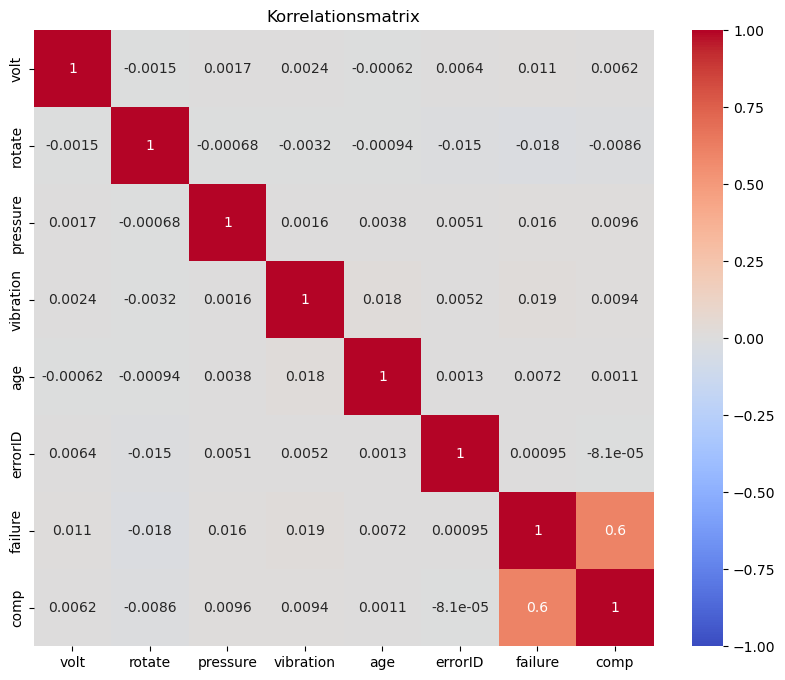

In [15]:
# Erstellt eine Kopie des DataFrames und wandelt die Strings in 'errorID', 'failure' und 'comp' in int-Werte um
# NaN-Werte werden als 0 und andere Werte als 1 behandelt
db_bfr = df.copy()
db_bfr['errorID'] = db_bfr['errorID'].apply(lambda x: 0 if pd.isnull(x) else 1)
db_bfr['failure'] = db_bfr['failure'].apply(lambda x: 0 if pd.isnull(x) else 1)
db_bfr['comp'] = db_bfr['comp'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Berechnet die Korrelation zwischen den relevanten Spalten
correlation = db_bfr[['volt', 'rotate', 'pressure', 'vibration', 'age', 'errorID', 'failure', 'comp']].corr()

# Visualisiert die Korrelationen als Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korrelationsmatrix')
plt.show()

Zur Untersuchung der Korrelation werden zunächst die Spalten errorID, failure und comp in numerische Werte umgewandelt, wobei NaN-Werte als 0 und alle anderen als 1 interpretiert werden. Anschließend wird eine Korrelationsmatrix berechnet, die die linearen Zusammenhänge zwischen den Variablen volt, rotate, pressure, vibration, age, errorID, failure und comp darstellt. Diese wird mit einer Heatmap visualisiert. Die Darstellung ermöglicht es, potenzielle Zusammenhänge und Einflussfaktoren auf Fehler und Ausfälle zu erkennen. Dabei ist in diesem Fall eine Korrelation zwischen failure und comp erkennbar.

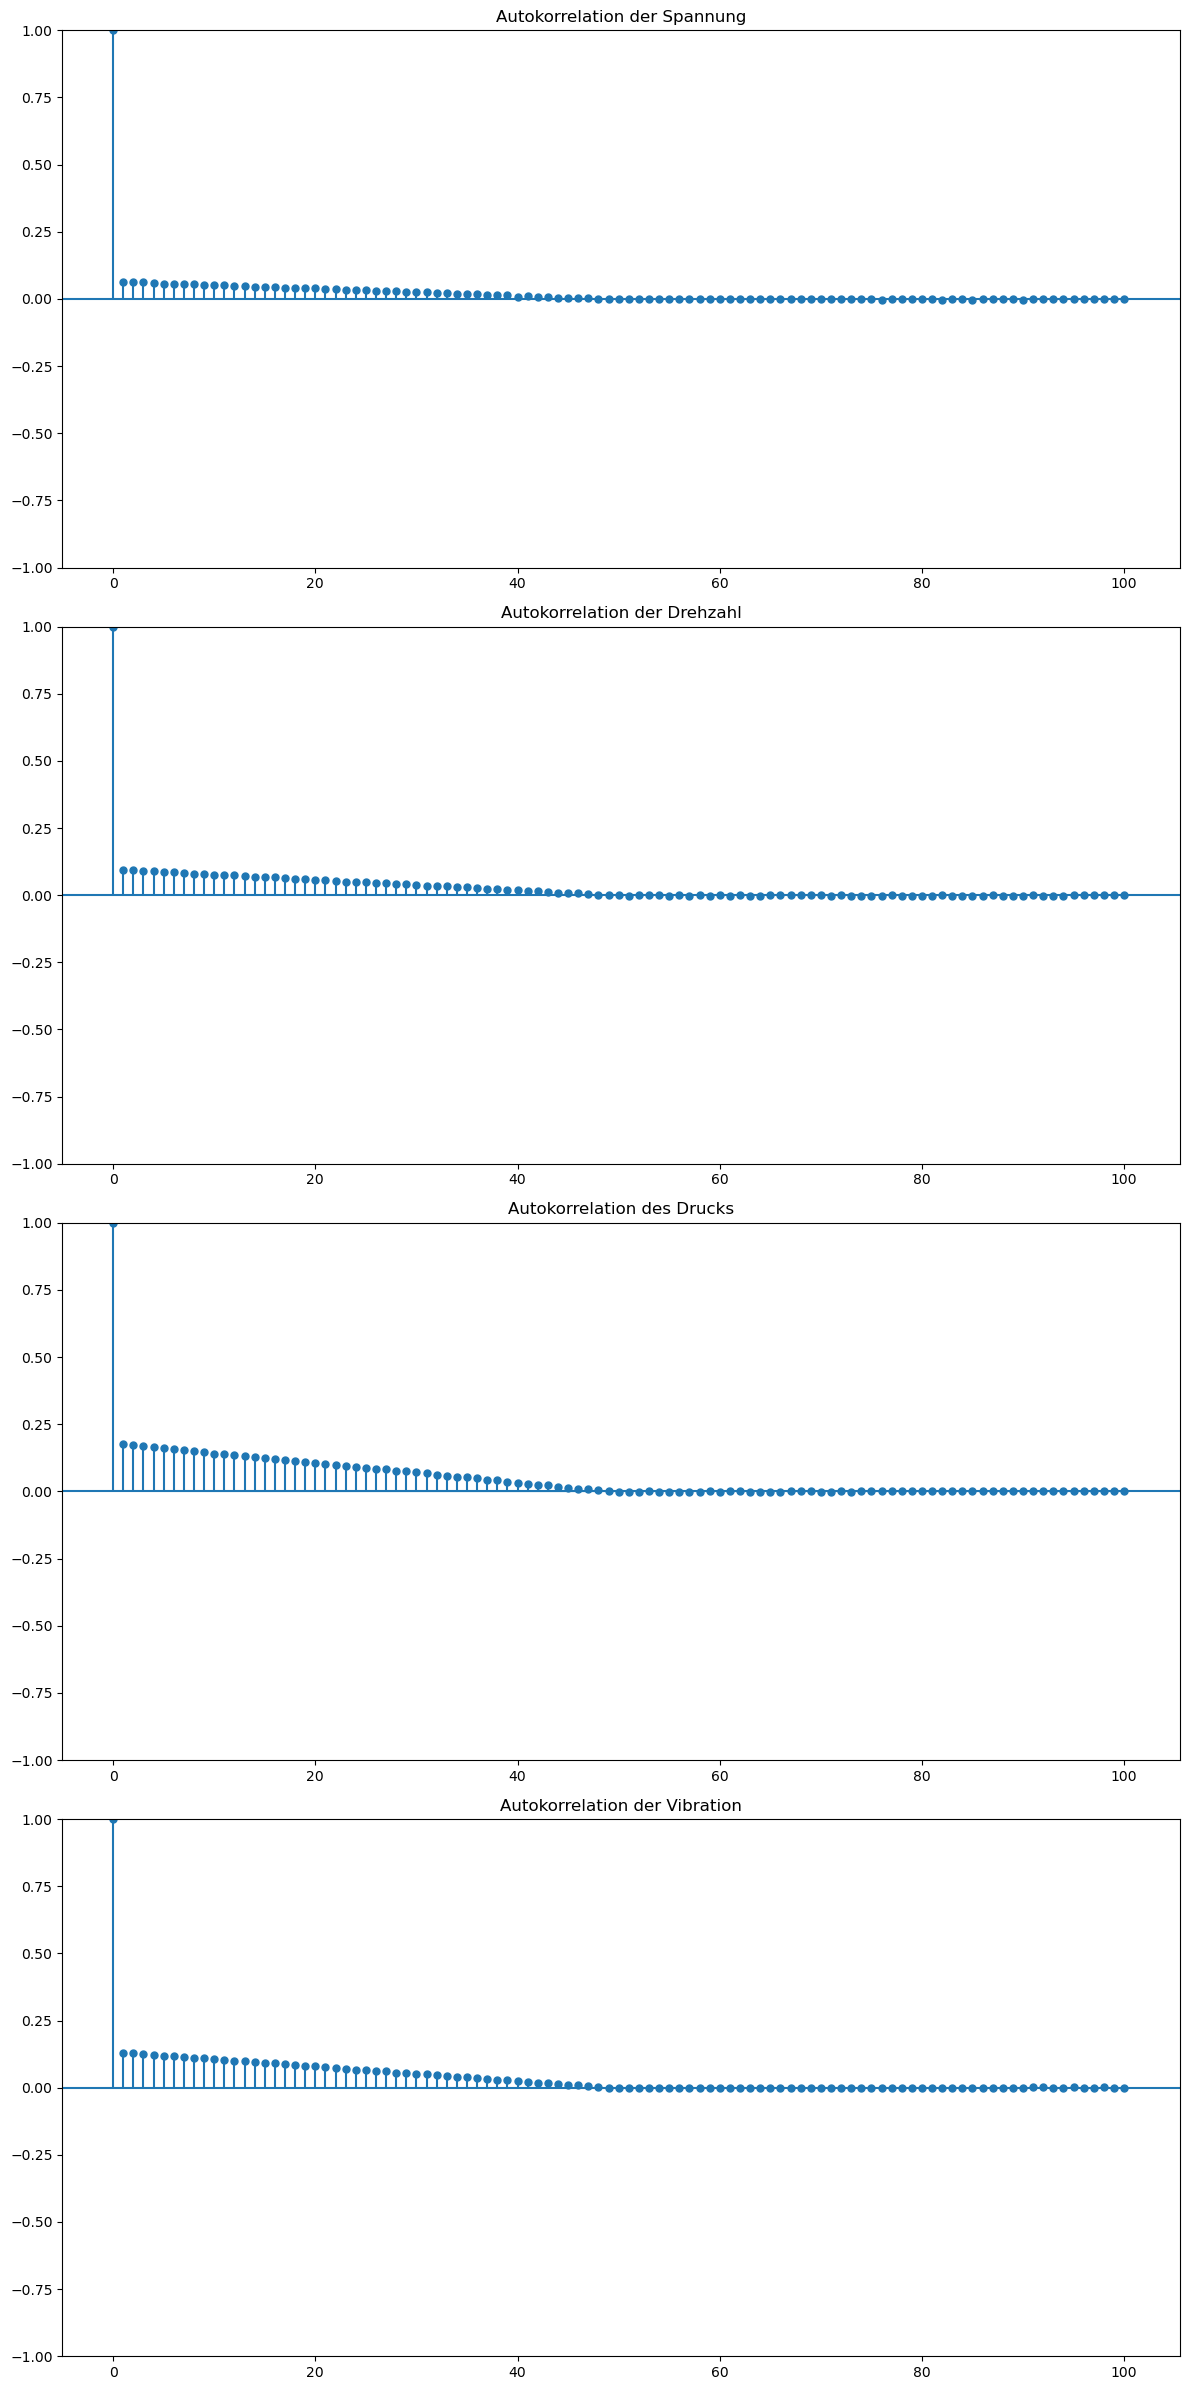

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

# Erstellt ein 4x1 Subplot mit einer Gesamtgröße von 12x24
fig, axs = plt.subplots(4, 1, figsize=(12, 24))

# Berechnet und plottet die Autokorrelation für 'volt' mit 100 Lags
plot_acf(df['volt'], lags=100, ax=axs[0])
axs[0].set_title('Autokorrelation der Spannung')

# Berechnet und plottet die Autokorrelation für 'rotate' mit 100 Lags
plot_acf(df['rotate'], lags=100, ax=axs[1])
axs[1].set_title('Autokorrelation der Drehzahl')

# Berechnet und plottet die Autokorrelation für 'pressure' mit 100 Lags
plot_acf(df['pressure'], lags=100, ax=axs[2])
axs[2].set_title('Autokorrelation des Drucks')

# Berechnet und plottet die Autokorrelation für 'vibration' mit 100 Lags
plot_acf(df['vibration'], lags=100, ax=axs[3])
axs[3].set_title('Autokorrelation der Vibration')

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()
plt.show()

Anschließend wird die Autokorrelation für die Variablen volt (Spannung), rotate (Drehzahl), pressure (Druck) und vibration (Vibration) berechnet und in separaten Plots dargestellt. Autokorrelation beschreibt, wie stark eine Zeitreihe mit sich selbst in unterschiedlichen Zeitabständen (Lags) korreliert.

Jeder Plot zeigt die Autokorrelation für bis zu 100 Lags, also Zeitpunkte, die jeweils um eine bestimmte Anzahl von Intervallen voneinander entfernt sind. Ein Wert nahe 1 deutet auf eine starke positive Korrelation hin, ein Wert nahe -1 auf eine starke negative Korrelation. Werte nahe 0 zeigen keine Korrelation. Die Plots ermöglichen es, Muster oder saisonale Abhängigkeiten in den Zeitreihen zu identifizieren.

In allen vier Fällen ist eine schwache Korrelation von höchstens 0,2 zu erkennen.







### Ausfälle pro Maschine

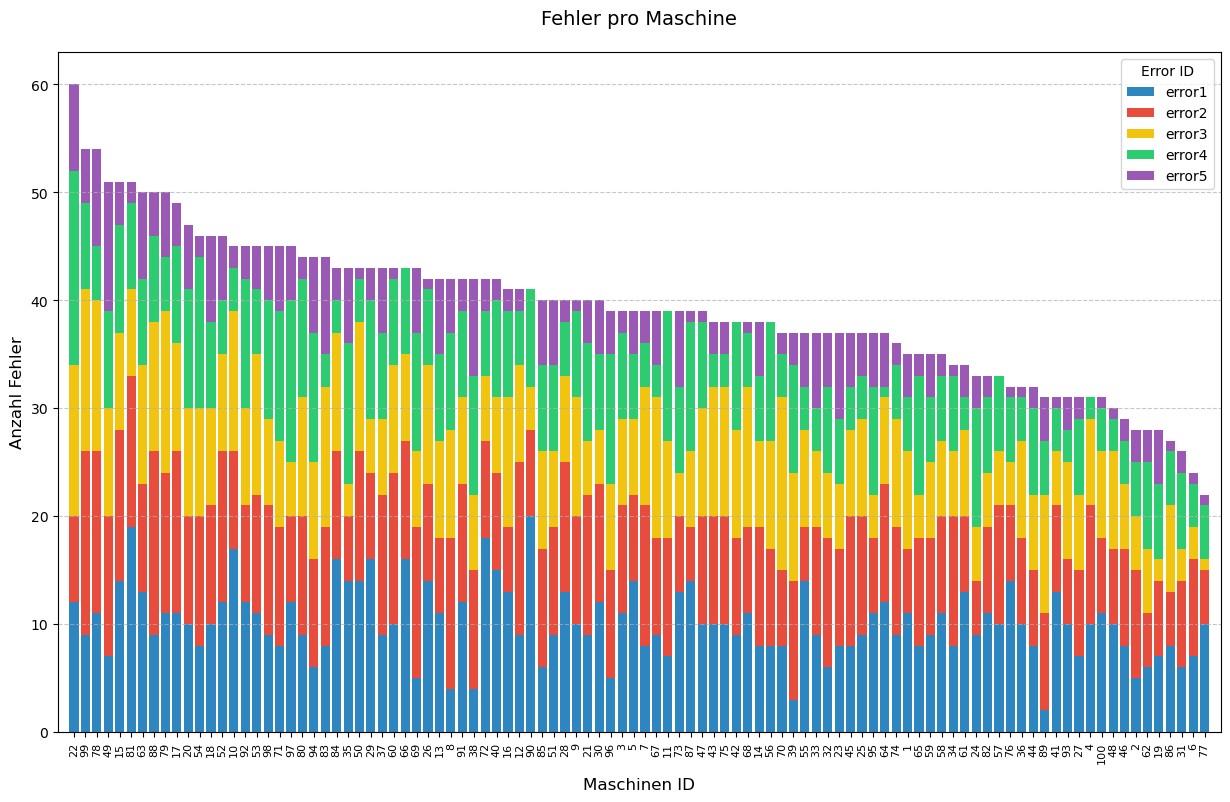

In [17]:
# Berechnet die Anzahl der Ausfälle pro Maschine und errorID und erstellt ein DataFrame, das nach der Gesamtzahl der Fehler pro Maschine sortiert wird
failure_count = df.groupby(['machineID', 'errorID']).size().unstack(fill_value=0)
failure_count_sorted = failure_count.sum(axis=1).sort_values(ascending=False)

# Erstellt eine Figur mit angepasster Größe
plt.figure(figsize=(15, 10))  

# Erstellt ein gestapeltes Balkendiagramm
bottom = np.zeros(len(failure_count_sorted))
colors = ['#2E86C1', '#E74C3C', '#F1C40F', '#2ECC71', '#9B59B6']  

for i, errorID in enumerate(failure_count.columns):
    values = failure_count.loc[failure_count_sorted.index, errorID]
    plt.bar(range(len(failure_count_sorted)), values, bottom=bottom, color=colors[i % len(colors)], label=errorID)
    bottom += values

# Setzt die X-Achsen-Labels auf die Maschinen-IDs und dreht sie um 90 Grad
plt.xticks(range(len(failure_count_sorted)), failure_count_sorted.index, 
           rotation=90,  
           ha='center',  
           fontsize=8)   

# Fügt Titel und Achsenbeschriftungen hinzu
plt.title('Fehler pro Maschine', fontsize=14, pad=20)
plt.xlabel('Maschinen ID', fontsize=12, labelpad=10)  
plt.ylabel('Anzahl Fehler', fontsize=12)

# Fügt Gitterlinien zur Y-Achse hinzu
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Passt die Ränder an
plt.margins(x=0.01)

# Passt den unteren Rand an, um Platz für die X-Achsen-Beschriftungen zu schaffen
plt.subplots_adjust(bottom=0.2)  

# Fügt eine Legende hinzu
plt.legend(title='Error ID')

# Zeigt das Diagramm an
plt.show()

Um die Ausfälle pro Maschine untersuchen zu können, wird ein gestapeltes Balkendiagramm erstellt, das die Anzahl der Fehler pro Maschine und Fehler-ID darstellt. Zunächst werden die Fehlerdaten nach machineID und errorID gruppiert und die Anzahl der Fehler berechnet, wobei fehlende Werte mit 0 aufgefüllt werden. Anschließend werden die Maschinen nach der Gesamtanzahl ihrer Fehler sortiert. Im Diagramm repräsentiert jeder Balken die Gesamtanzahl der Fehler pro Maschine. Das Diagramm ermöglicht es, die fehleranfälligsten Maschinen sowie die Verteilung der Fehlerarten zu erkennen.

### Anzahl an Fehlerklassen

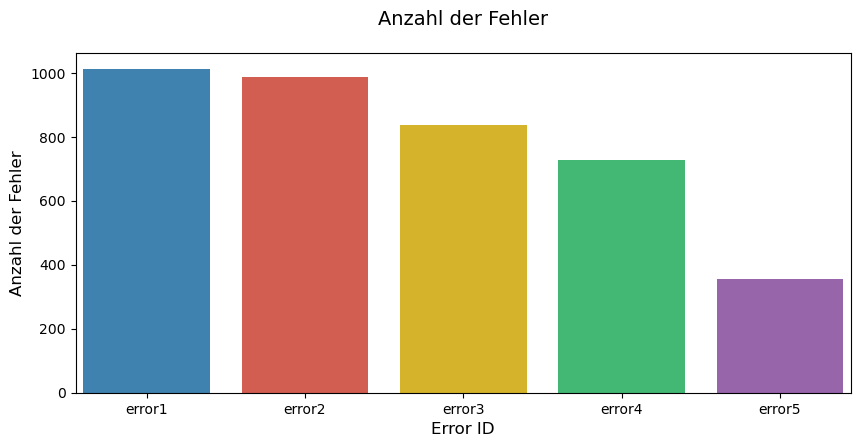

In [18]:
# Erstellt eine Figur mit einer Größe von 10x5 Zoll
plt.figure(figsize=(10, 5))

# Erstellt ein Balkendiagramm mit der x-Achse als Error-Klasse ('errorID') und der y-Achse als Anzahl der Fehler
# Die Reihenfolge der Balken basiert auf der Häufigkeit der Fehler
sns.countplot(x='errorID', data=df, order=df['errorID'].value_counts().index, palette=colors)

# Fügt Titel und Achsenbeschriftungen hinzu
plt.title('Anzahl der Fehler', fontsize=14, pad=20)
plt.ylabel('Anzahl der Fehler', fontsize=12)
plt.xlabel('Error ID', fontsize=12)

# Passt die Ränder und Abstände an
plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)

# Zeigt das Diagramm an
plt.show()

Mittels eines Balkendiagramms wird die Verteilung der Fehlerarten visualisiert. Dabei wird auf der x-Achse die errorID (Fehlerklasse) und auf der y-Achse die Anzahl der Fehler dargestellt. Die Fehlerarten werden nach ihrer Häufigkeit sortiert. 

### Anzahl der Ausfälle

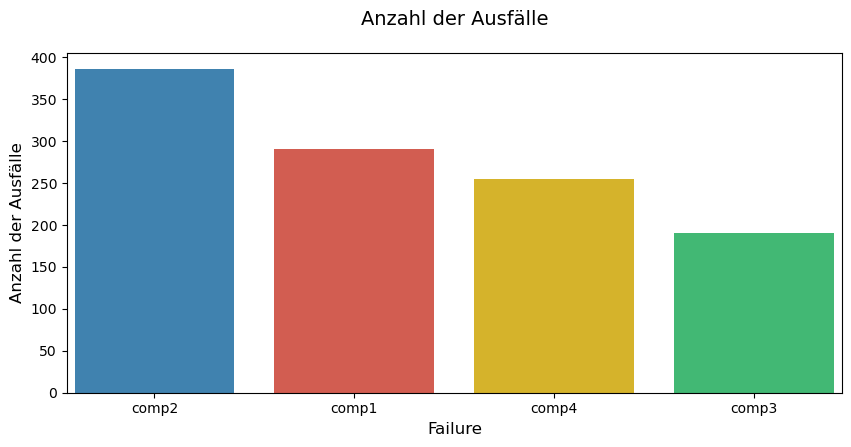

In [19]:
# Erstellt eine Figur mit einer Größe von 10x5 Zoll
plt.figure(figsize=(10, 5))

# Erstellt ein Balkendiagramm mit der x-Achse als Failure-Klasse ('failure') und der y-Achse als Anzahl der Ausfälle
# Die Reihenfolge der Balken basiert auf der Häufigkeit der Ausfälle
sns.countplot(x='failure', data=df, order=df['failure'].value_counts().index, palette=colors)

# Fügt Titel und Achsenbeschriftungen hinzu
plt.title('Anzahl der Ausfälle', fontsize=14, pad=20)
plt.ylabel('Anzahl der Ausfälle', fontsize=12)
plt.xlabel('Failure', fontsize=12)

# Passt die Ränder und Abstände an
plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)

# Zeigt das Diagramm an
plt.show()

Ebenso wie bei zuvor dargestellten Anzahl der Fehler können auch die Anzahl der Ausfälle visualisiert werden. Auch hier lässt sich im erstellten Diagramm erkennen, welche Art der Ausfälle wie häufig vorkommt.

### Verteilung des Alters der Maschinen

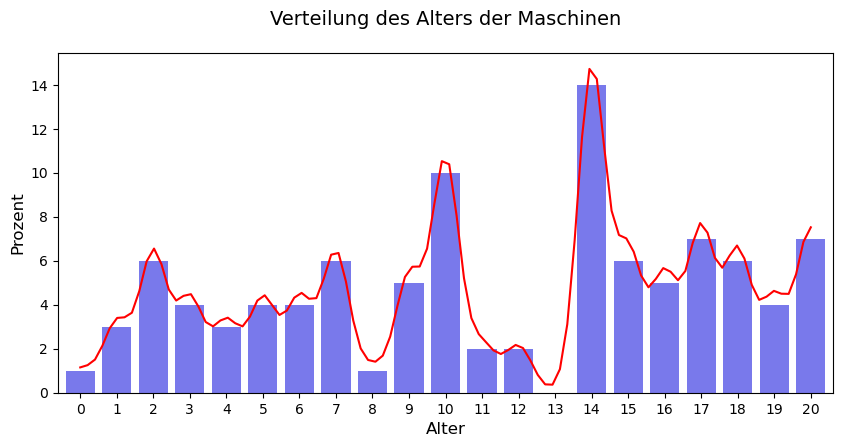

In [20]:
# Berechnet die Verteilung des Alters der Maschinen in Prozent
age_distribution = df['age'].value_counts(normalize=True) * 100

# Fügt Alter 13 mit 0% zur Verteilung hinzu
age_distribution = age_distribution.reindex(range(21), fill_value=0)

# Erstellt eine Figur mit einer Größe von 10x5 Zoll
plt.figure(figsize=(10, 5))

# Erstellt ein Balkendiagramm mit x = Alter und y = Prozent
sns.barplot(x=age_distribution.index, y=age_distribution.values, color='b', alpha=0.6)

# Fügt eine Dichtekurve für das Alter hinzu
age_values = df['age'].values
kde = gaussian_kde(age_values)
age_range = np.linspace(age_values.min(), age_values.max(), 100)
age_density = kde(age_range) * 100  # Skalieren auf Prozent

# Plottet die Dichtekurve
plt.plot(age_range, age_density, color='r')

# Fügt Titel und Achsenbeschriftungen hinzu
plt.title('Verteilung des Alters der Maschinen', fontsize=14, pad=20)
plt.ylabel('Prozent', fontsize=12)
plt.xlabel('Alter', fontsize=12)

# Passt die Ränder und Abstände an
plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)

# Zeigt das Diagramm an
plt.show()

Anhand des erstellten Säulendiagramms lässt sich die Verteilung des Alters der untersuchten Maschinen darstellen. Dabei wird auf der x-Achse das mögliche Alter abgebildet und auf der y-Achse die Verteilung in Prozent. Die meisten Maschinen sind dabei zehn oder 14 Jahre alt.

### Linearer Zusammenhang (Regression) mit der Anzahl an Ausfällen und dem Alter der Maschine

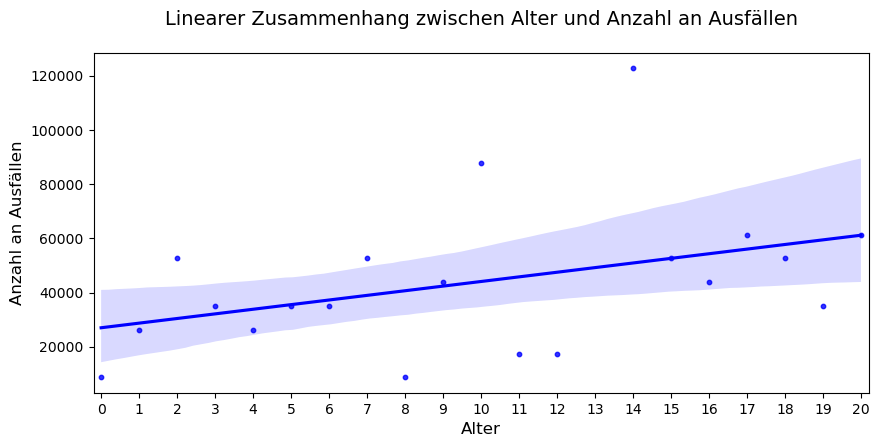

Die Funktion der Geraden lautet: y = 1707.3372559332063x + 27043.178029057915


In [21]:
# Zählt die Anzahl der Ausfälle pro Alter und speichert das Ergebnis in 'age_error_count'
age_error_count = df.groupby('age').size()

# Erstellt eine Figur mit einer Größe von 10x5 Zoll für die lineare Darstellung
plt.figure(figsize=(10, 5))

# Erstellt ein Streudiagramm mit einer linearen Regressionslinie
sns.regplot(x=age_error_count.index, y=age_error_count.values, color='b', scatter_kws={'s': 10})

# Fügt Titel und Achsenbeschriftungen hinzu
plt.title('Linearer Zusammenhang zwischen Alter und Anzahl an Ausfällen', fontsize=14, pad=20)
plt.ylabel('Anzahl an Ausfällen', fontsize=12)
plt.xlabel('Alter', fontsize=12)

# Setzt die x-Achse so, dass jedes Jahr als Strich dargestellt wird
plt.xticks(ticks=range(age_error_count.index.min(), age_error_count.index.max() + 1))

# Passt die Ränder und Abstände an
plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)

# Zeigt das Diagramm an
plt.show()

# Berechnet die Regressionsgerade
X = age_error_count.index.values.reshape(-1, 1)
y = age_error_count.values

# Erstellt das Regressionsmodell und trainiert es
model = LinearRegression()
model.fit(X, y)

# Gibt die Funktionsgleichung der Regressionsgeraden aus
m = model.coef_[0]
b = model.intercept_
print(f"Die Funktion der Geraden lautet: y = {m}x + {b}")

Im Bereich der Datenbeschreibung wird abschließend noch der Zusammenhang zwischen dem Alter der Maschinen und der Anzahl an Ausfällen visualisiert. Zuerst wird die Anzahl der Ausfälle für jedes Alter summiert. Anschließend wird ein Streudiagramm mit einer linearen Regressionsgeraden erstellt, um den Trend zwischen Alter und Ausfällen darzustellen. Die x-Achse zeigt das Alter der Maschinen und die y-Achse die Anzahl der Ausfälle. Ein lineares Regressionsmodell wird trainiert, um die beste Geradengleichung zu berechnen, die den Zusammenhang beschreibt. Die Koeffizienten der Regressionsgeraden werden schließlich ausgegeben.

## Datenvorberarbeitung


### Umwandlung einzelner Spalten in integer-Werte

In [22]:
# Wandelt die Spalten 'errorID', 'failure', 'comp' und 'model' in numerische Werte um
# Füllt NaN-Werte mit 0 und ersetzt die entsprechenden Textwerte durch numerische Werte

# Umwandlung der 'errorID'-Spalte
df['errorID'] = df['errorID'].fillna(0)  # NaN-Werte mit 0 ersetzen
df['errorID'] = df['errorID'].replace('error1', 1)
df['errorID'] = df['errorID'].replace('error2', 2)
df['errorID'] = df['errorID'].replace('error3', 3)
df['errorID'] = df['errorID'].replace('error4', 4)
df['errorID'] = df['errorID'].replace('error5', 5)

# Umwandlung der 'failure'-Spalte
df['failure'] = df['failure'].fillna(0)  # NaN-Werte mit 0 ersetzen
df['failure'] = df['failure'].replace('comp1', 1)
df['failure'] = df['failure'].replace('comp2', 2)
df['failure'] = df['failure'].replace('comp3', 3)
df['failure'] = df['failure'].replace('comp4', 4)

# Umwandlung der 'comp'-Spalte
df['comp'] = df['comp'].fillna(0)  # NaN-Werte mit 0 ersetzen
df['comp'] = df['comp'].replace('comp1', 1)
df['comp'] = df['comp'].replace('comp2', 2)
df['comp'] = df['comp'].replace('comp3', 3)
df['comp'] = df['comp'].replace('comp4', 4)

# Umwandlung der 'model'-Spalte
df['model'] = df['model'].fillna(0)  # NaN-Werte mit 0 ersetzen
df['model'] = df['model'].replace('model1', 1)
df['model'] = df['model'].replace('model2', 2)
df['model'] = df['model'].replace('model3', 3)
df['model'] = df['model'].replace('model4', 4)

Im ersten Schritt der Datenvorverarbeitung werden die Spalten errorID, failure, comp und model umgewandelt, damit sie nur noch numerische Werte enthalten. Zuerst werden alle NaN-Werte in diesen Spalten durch 0 ersetzt. Danach werden die einzelnen Kategorien, wie beispielweise error1, error2, comp1 oder comp2 durch numerische Werte ersetzt: error1 wird zu 1, error2 zu 2 etc. Dies wird für alle genannten Spalten durchgeführt. Dadurch liegen alle Werte in diesen Spalten als numerische Werte vor und können so für die weitere Analyse verwendet werden.

### Missing Value Treatment

In [23]:
# Gibt die Anzahl der fehlenden Werte pro Spalte im DataFrame aus
print(df.isnull().sum())

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
errorID      0
failure      0
comp         0
model        0
age          0
dtype: int64


Beim Missing Value Treatment wird der Dataframe auf fehlende Werte überprüft. Dies ist hier jedoch nicht der Fall, da für alle Variablen der Wert 0 ausgegeben wird. Dadurch ist ebenfalls keine Interpolation oder ähnliches notwendig.

### Ausreißer-Analyse (statistisch und dichtebasiert)

#### Data Cleaning (Ausreißer identifizieren und ggf. entfernen)

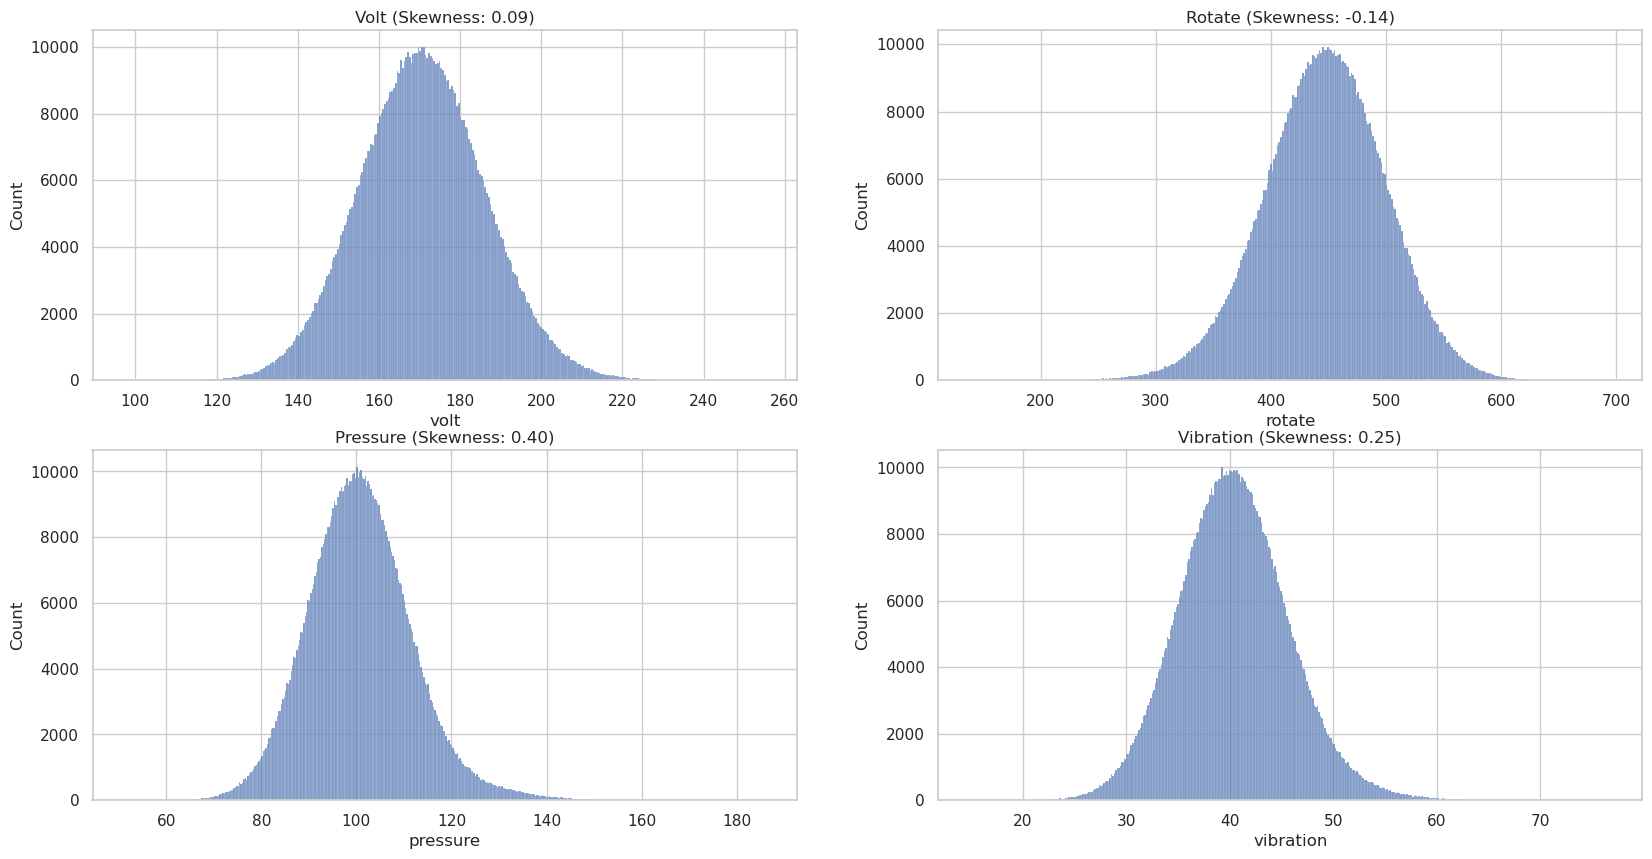

In [24]:
# Setzt den Stil der Visualisierung auf ein klares Gitter
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Histogramm für 'volt' erstellen und Skewness anzeigen
plt.subplot(2, 2, 1)
sns.histplot(df['volt'])
plt.title(f'Volt (Skewness: {df["volt"].skew():.2f})')

# Histogramm für 'rotate' erstellen und Skewness anzeigen
plt.subplot(2, 2, 2)
sns.histplot(df['rotate'])
plt.title(f'Rotate (Skewness: {df["rotate"].skew():.2f})')

# Histogramm für 'pressure' erstellen und Skewness anzeigen
plt.subplot(2, 2, 3)
sns.histplot(df['pressure'])
plt.title(f'Pressure (Skewness: {df["pressure"].skew():.2f})')

# Histogramm für 'vibration' erstellen und Skewness anzeigen
plt.subplot(2, 2, 4)
sns.histplot(df['vibration'])
plt.title(f'Vibration (Skewness: {df["vibration"].skew():.2f})')

# Zeigt das Diagramm an
plt.show()

Für das Data Cleaning werden die Verteilungen der vier Attribute volt, rate, pressure und vibration mithilfe von Histogrammen visualisiert. Für jedes Attribut wird zusätzlich die Schiefe berechnet, die im Titel des jeweiligen Plots angezeigt wird. Die Schiefe gibt an, wie asymmetrisch die Verteilung der Daten ist. Ein Wert von 0 deutet auf eine symmetrische Verteilung hin, während positive oder negative Werte auf eine Rechts- bzw. Linksschiefe hinweisen. Diese Visualisierung hilft dabei, die Verteilungen der Attribute besser zu verstehen und zu erkennen, ob sie einer Normalverteilung entsprechen oder signifikante Verzerrungen aufweisen.

In [25]:
# Berechnung und Ausgabe der Mittelwerte, Mediane und Standardabweichungen für die relevanten Spalten

# Mittelwert
print("Volt-Mittelwert: ", df['volt'].mean())
print("Rotation-Mittelwert: ", df['rotate'].mean())
print("Pressure-Mittelwert: ", df['pressure'].mean())
print("Vibration-Mittelwert: ", df['vibration'].mean())

# Median
print("Volt-Median: ", df['volt'].median())
print("Rotation-Median: ", df['rotate'].median())
print("Pressure-Median: ", df['pressure'].median())
print("Vibration-Median: ", df['vibration'].median())

# Standardabweichung
print("Volt-Standardabweichung: ", df['volt'].std())
print("Rotation-Standardabweichung: ", df['rotate'].std())
print("Pressure-Standardabweichung: ", df['pressure'].std())
print("Vibration-Standardabweichung: ", df['vibration'].std())


Volt-Mittelwert:  170.78094187513804
Rotation-Mittelwert:  446.5707350330433
Pressure-Mittelwert:  100.86143292362102
Vibration-Mittelwert:  40.386458969965
Volt-Median:  170.609301144424
Rotation-Median:  447.53753810681
Pressure-Median:  100.426820431081
Vibration-Median:  40.2383389800242
Volt-Standardabweichung:  15.511268213588925
Rotation-Standardabweichung:  52.698962770319774
Pressure-Standardabweichung:  11.0521952150491
Vibration-Standardabweichung:  5.371894442197934


In diesem Code wird eine statistische Ausreißer-Analyse für die vier Attribute volt, rotate, pressure und vibration durchgeführt. Es werden der Mittelwert, der Median und die Standardabweichung als zentrale Kennwerte berechnet. Der Mittelwert gibt den Durchschnitt der Werte an und kann durch extreme Ausreißer verzerrt werden. Der Median stellt den zentralen Wert der Verteilung dar und ist weniger empfindlich gegenüber Ausreißern. Die Standardabweichung misst die Streuung der Werte um den Mittelwert und hilft, die Variabilität der Daten zu verstehen. Diese Kennzahlen bieten eine Grundlage, um mögliche Ausreißer zu identifizieren, die sich signifikant vom Mittelwert oder Median unterscheiden oder eine hohe Streuung aufweisen.

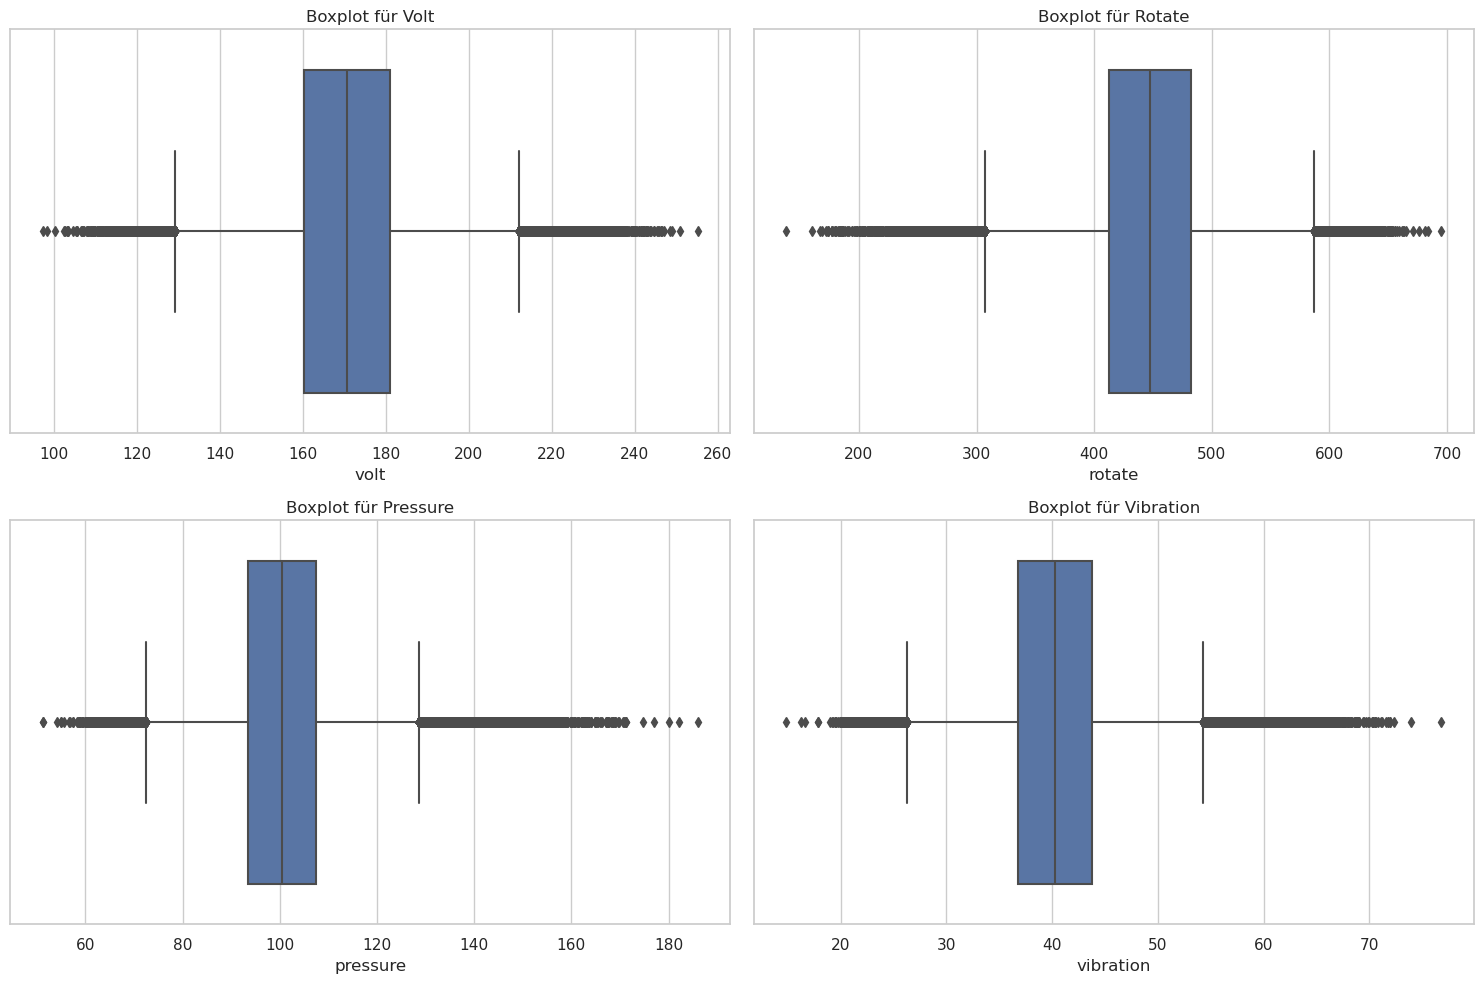

Anzahl der Ausreißer (volt):  7480
Anzahl der Ausreißer (rotate):  8595
Anzahl der Ausreißer (pressure):  15634
Anzahl der Ausreißer (vibration):  11146


In [26]:
# Erstellt ein 2x2 Subplot mit einer Größe von 15x10 Zoll für die Boxplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Boxplot für 'volt'
sns.boxplot(x=df['volt'], ax=axs[0, 0])
axs[0, 0].set_title('Boxplot für Volt')

# Boxplot für 'rotate'
sns.boxplot(x=df['rotate'], ax=axs[0, 1])
axs[0, 1].set_title('Boxplot für Rotate')

# Boxplot für 'pressure'
sns.boxplot(x=df['pressure'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot für Pressure')

# Boxplot für 'vibration'
sns.boxplot(x=df['vibration'], ax=axs[1, 1])
axs[1, 1].set_title('Boxplot für Vibration')

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()
plt.show()

# Berechnet die Ausreißer für 'volt' basierend auf dem Interquartilsabstand (IQR)
Q1_volt = df['volt'].quantile(0.25)
Q3_volt = df['volt'].quantile(0.75)
IQR_volt = Q3_volt - Q1_volt

# Gibt die Anzahl der Ausreißer für 'volt' aus
print("Anzahl der Ausreißer (volt): ", ((df['volt'] < (Q1_volt - 1.5 * IQR_volt)) | (df['volt'] > (Q3_volt + 1.5 * IQR_volt))).sum())

# Berechnet die Ausreißer für 'rotate' basierend auf dem IQR
Q1_rotate = df['rotate'].quantile(0.25)
Q3_rotate = df['rotate'].quantile(0.75)
IQR_rotate = Q3_rotate - Q1_rotate

# Gibt die Anzahl der Ausreißer für 'rotate' aus
print("Anzahl der Ausreißer (rotate): ", ((df['rotate'] < (Q1_rotate - 1.5 * IQR_rotate)) | (df['rotate'] > (Q3_rotate + 1.5 * IQR_rotate))).sum())

# Berechnet die Ausreißer für 'pressure' basierend auf dem IQR
Q1_pressure = df['pressure'].quantile(0.25)
Q3_pressure = df['pressure'].quantile(0.75)
IQR_pressure = Q3_pressure - Q1_pressure

# Gibt die Anzahl der Ausreißer für 'pressure' aus
print("Anzahl der Ausreißer (pressure): ", ((df['pressure'] < (Q1_pressure - 1.5 * IQR_pressure)) | (df['pressure'] > (Q3_pressure + 1.5 * IQR_pressure))).sum())

# Berechnet die Ausreißer für 'vibration' basierend auf dem IQR
Q1_vibration = df['vibration'].quantile(0.25)
Q3_vibration = df['vibration'].quantile(0.75)
IQR_vibration = Q3_vibration - Q1_vibration

# Gibt die Anzahl der Ausreißer für 'vibration' aus
print("Anzahl der Ausreißer (vibration): ", ((df['vibration'] < (Q1_vibration - 1.5 * IQR_vibration)) | (df['vibration'] > (Q3_vibration + 1.5 * IQR_vibration))).sum())


Ebenfalls durchgeführt wird eine Ausreißer-Analyse für die Attribute volt, rotate, pressure und vibration. Auch hier werden Boxplots erstellt, um visuell Ausreißer zu identifizieren. Anschließend wird der Interquartilsabstand (IQR) berechnet, und Ausreißer werden als Werte außerhalb des Bereichs Q1 - 1.5 * IQR und Q3 + 1.5 * IQR bestimmt. Die Anzahl der Ausreißer für jedes Attribut wird gezählt und angezeigt. Es ergibt sich eine Anzahl von 7480 Ausreißern in der gesamten Analyse und insgesamt die meisten Ausreißer für das Attribut pressure.

Hier schreiben, dass die Ausreißer zwar identifiziert wurden, aber nicht entfernt werden, da sie für die Analyse wichtig sind. Es sind keine Ausreißer vorhanden, die sehr unrealistisch sind.

### Feature Engineering

In [27]:
# Erstellt eine neue Spalte 'volt_rotate' als Produkt von 'volt' und 'rotate'
df['volt_rotate'] = df['volt'] * df['rotate']

# Erstellt eine neue Spalte 'pressure_vibration' als Produkt von 'pressure' und 'vibration'
df['pressure_vibration'] = df['pressure'] * df['vibration']

# Gibt die ersten fünf Zeilen des DataFrames aus, um die neuen Spalten zu überprüfen
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,3,18,73747.890142,5098.422421
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,3,18,65599.198124,4144.320641
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0,0,3,18,90171.495188,2571.544848
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0,0,3,18,56236.401704,4492.535078
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0,0,3,18,68619.758183,2907.991161


Im Rahmen der Datenvorverarbeitung wird nun Feature Engineering durchgeführt, um neue Merkmake (Features) zu erstellen, die durch Kombination bestehender Attribute entstehen. Volt und Rotate bilden das Attribut volt_rotate, Pressure und Vibration das Attribut pressure_vibration. Diese neuen Features könnten nützlich sein, um komplexe Zusammenhänge zwischen den bestehenden Variablen zu erfassen. 

### Datennormalisierung


In [28]:
# Importiert den MinMaxScaler zur Normalisierung der Daten
from sklearn.preprocessing import MinMaxScaler
import joblib

# Normalisiert die angegebenen Spalten auf Werte zwischen 0 und 1
scaler = MinMaxScaler()
df[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']] = scaler.fit_transform(df[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']])

# Speichert den Scaler für die spätere Verwendung
joblib.dump(scaler, 'data/scaler.pkl')

# Gibt die ersten fünf Zeilen des DataFrames aus, um die normalisierten Werte zu überprüfen
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration
0,2015-01-01 06:00:00,1,0.499928,0.503194,0.459050,0.487945,0,0,0,3,0.9,0.436387,0.466004
1,2015-01-01 07:00:00,1,0.415395,0.474884,0.328274,0.460912,0,0,0,3,0.9,0.366571,0.344464
2,2015-01-01 08:00:00,1,0.466796,0.698752,0.178160,0.311752,0,0,0,3,0.9,0.577100,0.144115
3,2015-01-01 09:00:00,1,0.412756,0.373197,0.430624,0.423896,0,0,0,3,0.9,0.286353,0.388822
4,2015-01-01 10:00:00,1,0.382001,0.533508,0.450207,0.179498,0,0,0,3,0.9,0.392450,0.186973


Mithilfe des MinMaxScalers werden die Werte der Attribute volt, rotate, pressure, vibration und age normalisiert. Der MinMaxScaler skalsiert die Werte jedes Attributs auf einen Bereich zwischen 0 und 1. Die normalisierten Werte werden dann in die ursprüngliche DataFrame übernommen und das Ergebnis wird durch df.head() angezeigt.

### Datentransformation

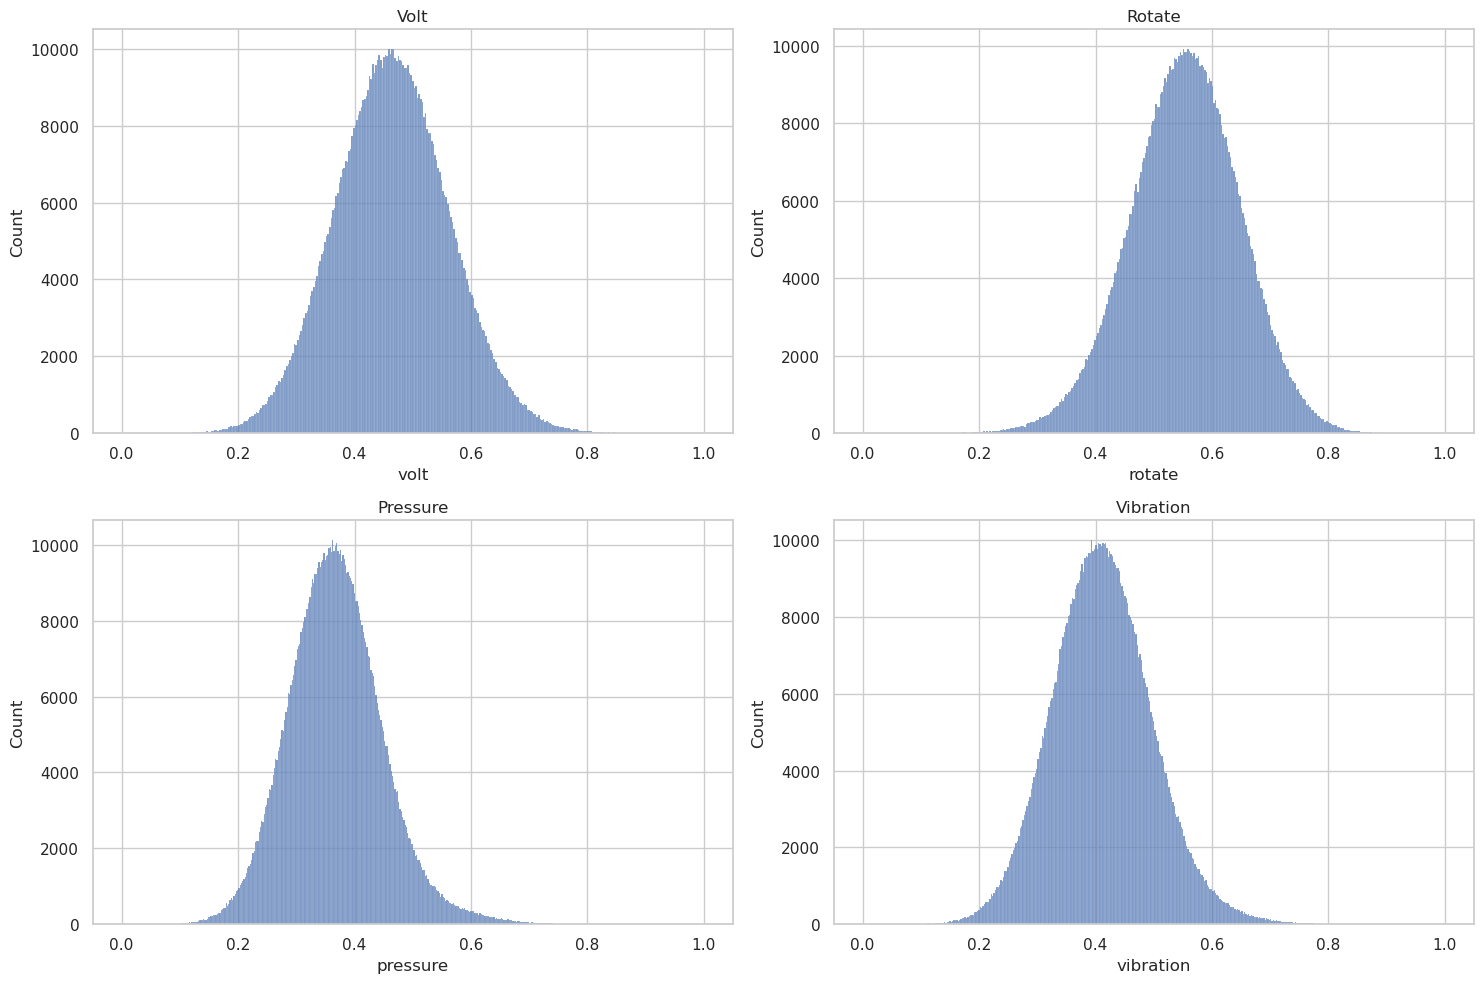

In [29]:
# Setzt den Stil der Visualisierung auf ein klares Gitter
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Histogramm für 'volt' erstellen
plt.subplot(2, 2, 1)
sns.histplot(df['volt'])
plt.title('Volt')

# Histogramm für 'rotate' erstellen
plt.subplot(2, 2, 2)
sns.histplot(df['rotate'])
plt.title('Rotate')

# Histogramm für 'pressure' erstellen
plt.subplot(2, 2, 3)
sns.histplot(df['pressure'])
plt.title('Pressure')

# Histogramm für 'vibration' erstellen
plt.subplot(2, 2, 4)
sns.histplot(df['vibration'])
plt.title('Vibration')

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()
plt.show()

Nach der Datennormalisierung besteht nun auch die Möglichkeit, die Verteilungen der Attribute visuell darzustellen. Dafür werden wieder Histrogramme verwendet, die die normalisierten Daten für die einzelnen Attribute darstellen. Dieser Prozess hilft dabei, die Verteilung der Daten zu überprüfen und mögliche Abweichungen von einer normalen (Gaußschen) Verteilung zu erkennen.

Leicht schief teilweise, aber insgesamt gut normalisiert. (schön umschreiben ;)

### Feature Importance (der ersten 100.000 Messwerte)

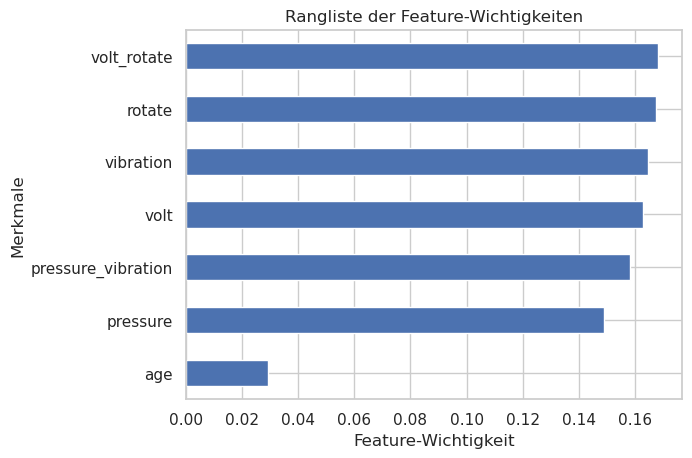

In [30]:
# Erstellt die Merkmale (X) und das Ziel (y) für das Modell
X = df[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']].head(100000)
y = df['failure'].head(100000)

# Initialisiert und trainiert ein RandomForestClassifier-Modell
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

# Extrahiert die Feature-Wichtigkeiten aus dem trainierten Modell
rf_feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Visualisiert die 10 wichtigsten Features basierend auf ihrer Wichtigkeit
rf_feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.xlabel('Feature-Wichtigkeit')
plt.ylabel('Merkmale')
plt.title('Rangliste der Feature-Wichtigkeiten')
plt.show()

# Erstellt eine Kopie der Rohdaten
data_raw = df.copy()

Als Abschluss im Rahmen der Datenvorverarbeitung wird ein Random Forest Classifier eingesetzt, um die Bedeutung der verschiedenen Merkmale im Hinblick auf die Vorhersage der Zielgröße failure zu bestimmen. Dazu werden die Eingabedaten aus den Attributen volt, rotate, pressure, vibration, age sowie zwei neu berechneten Merkmalen, volt_rotate und pressure_vibration, zusammengestellt. Die Zielvariable ist failure.

Der Random Forest wird anschließend mit den ersten 100.000 Datenpunkten trainiert. Nach dem Modelltraining werden die Feature Importances extrahiert, welche die relative Bedeutung jedes Merkmals für die Modellvorhersage darstellen. 

## Anomalieerkennung

Die Anomalieerkennung ist ein zentraler Bestandteil der Datenanalyse in der Predictive Maintenance und dient der Identifikation ungewöhnlicher Muster oder Werte, die auf potenzielle Fehler oder abweichende Betriebszustände hinweisen können. In diesem Projekt wird ein exemplarischer Ansatz zur Erkennung von Anomalien anhand verschiedener Methoden und Algorithmen vorgestellt. Dabei kommen sowohl unüberwachte Lernmethoden, wie DBSCAN und K-Means, als auch überwachtes Lernen und neuronale Netzwerke, beispielsweise Autoencoder und Random Forest, zum Einsatz. Ziel ist es, Anomalien in den Sensordaten zu identifizieren und diese sowohl analysieren als auch zu visualisiern. Da die Betrachtung aller Maschinen in der vorliegenden Datenbasis den Rahmen sprengen würde, wird exemplarisch die Maschine mit der ID 1 analysiert. Dieser Fokus gewährleistet eine übersichtliche und detaillierte Darstellung der Anomalieerkennung und ermöglicht es, die verschiedenen Algorithmen und deren Ergebnisse klar zu vergleichen. Die Erkenntnisse, die aus der Analyse von Maschine 1 gewonnen werden, lassen sich auf andere Maschinen übertragen, da die Methodik allgemeingültig ist. 

### DBSCAN-Algorithmus


Ausreißer-Statistiken:
Anzahl Ausreißer: 99


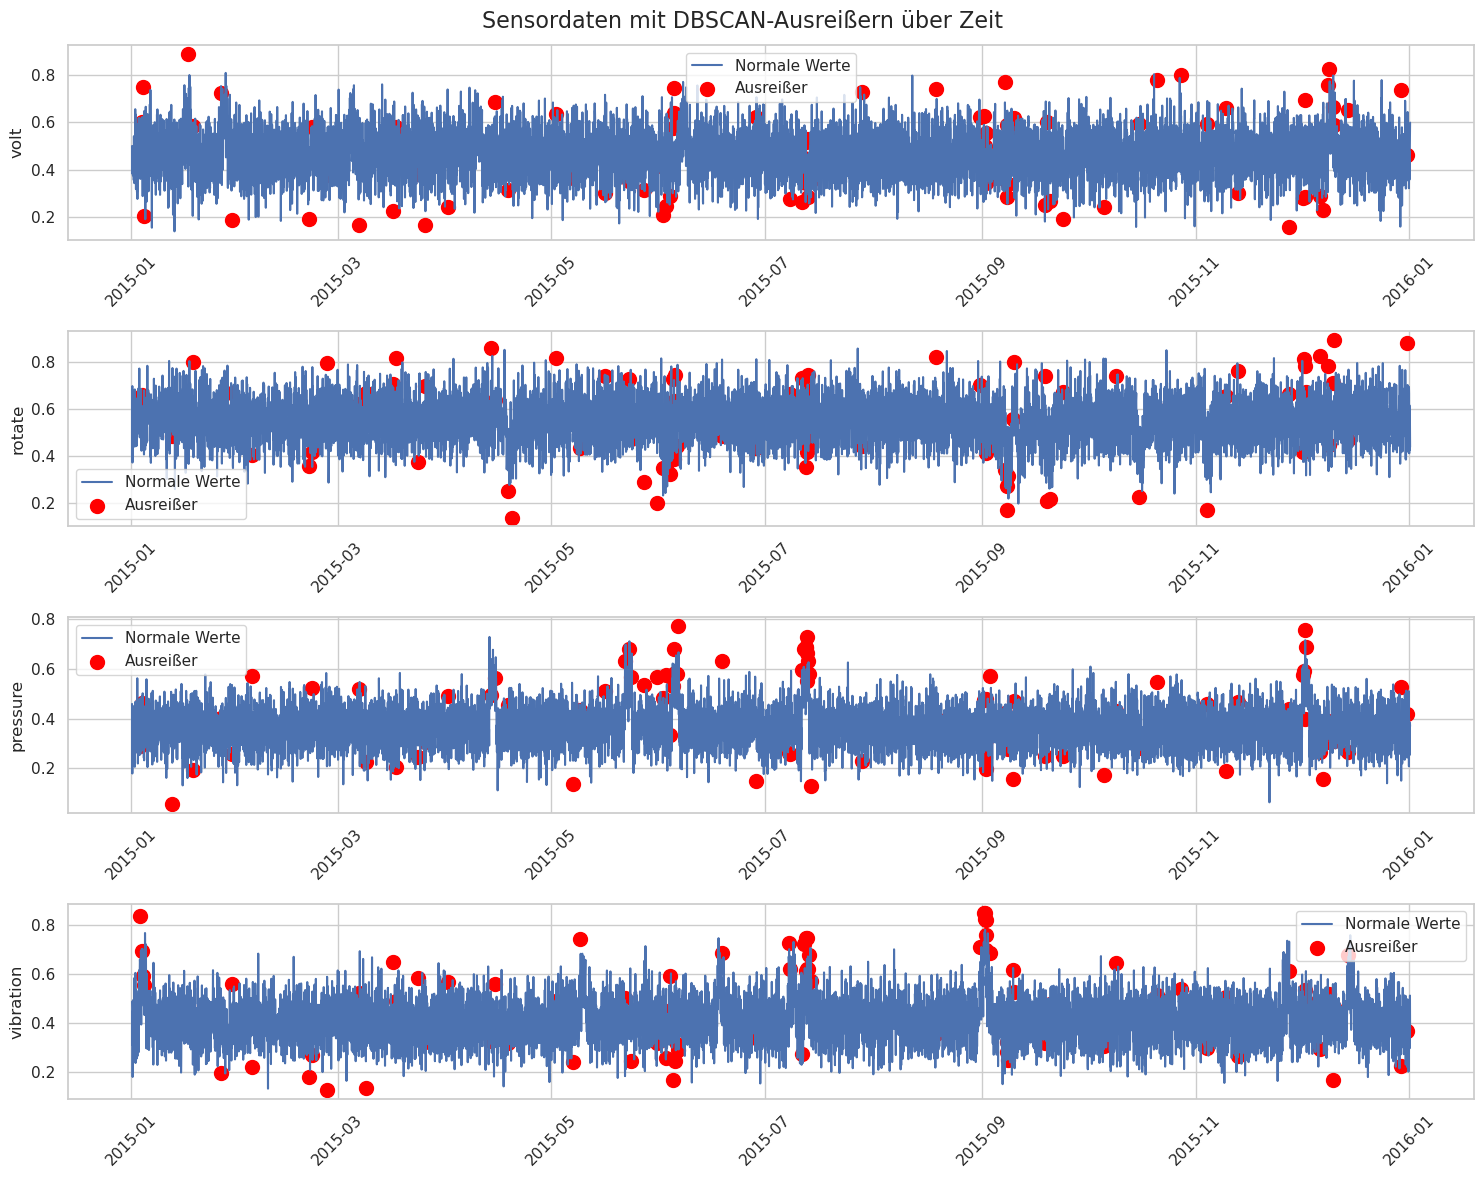

In [31]:
# Filtert die Daten für Maschine 1 und konvertiert den 'datetime' in ein datetime-Format
df_machine_1 = df[df['machineID'] == 1]
df_machine_1['datetime'] = pd.to_datetime(df_machine_1['datetime'])

# Wählt die relevanten Features aus
features = ['volt', 'rotate', 'pressure', 'vibration']
X = df_machine_1[features]

# Führt DBSCAN zur Ausreißererkennung durch
dbscan = DBSCAN(eps=0.075, min_samples=2)
dbscan_labels = dbscan.fit_predict(X)

# Identifiziert Ausreißer (Label -1)
outliers = df_machine_1[dbscan_labels == -1]
normal_points = df_machine_1[dbscan_labels != -1]

# Erstellt Subplots für jeden Sensor
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Sensordaten mit DBSCAN-Ausreißern über Zeit', fontsize=16)

# Plottet die normalen Punkte und Ausreißer für jedes Feature
for idx, feature in enumerate(features):
    # Plot der normalen Punkte
    axes[idx].plot(normal_points['datetime'], normal_points[feature], 'b-', label='Normale Werte')
    
    # Plot der Ausreißer als rote Punkte
    if len(outliers) > 0:
        axes[idx].scatter(outliers['datetime'], outliers[feature], color='red', marker='o', 
                         s=100, label='Ausreißer')
    
    # Formatierungen und Legende
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True)
    axes[idx].legend()
    
    # Rotiere x-Achsen Labels für bessere Lesbarkeit
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

# Optimiert das Layout
plt.tight_layout()

# Ausgabetext für Ausreißer-Statistiken
print("\nAusreißer-Statistiken:")
print(f"Anzahl Ausreißer: {len(outliers)}")

Bei der Implementierung kommen zwei zentrale Parameter zum Einsatz: eps, das die maximale Distanz zwischen zwei Punkten definiert, damit sie demselben Cluster zugeordnet werden, und min_samples, das die Mindestanzahl an Punkten bestimmt, die erforderlich ist, um einen Cluster zu bilden. In diesem Fall werden die Werte auf eps = 0.075 und min_samples = 2 gesetzt. Der Algorithmus identifiziert Cluster in den Sensordaten, wobei Punkte, die keinem Cluster zugeordnet werden können, als Anomalien klassifiziert werden.

Die Ergebnisse werden sowohl numerisch als auch visuell ausgewertet. Die Sensordaten werden dabei in normale Werte und Anomalien aufgeteilt. Für jedes Sensorattribut entstehen Zeitreihendiagramme, die normale Werte als blaue Linien und Anomalien als rote Punkte darstellen. Diese Visualisierung bietet eine klare Trennung zwischen normalen Betriebszuständen und potenziellen Anomalien.

Die statistische Auswertung zeigt, dass Anomalien unregelmäßig über den gesamten Zeitraum auftreten und sich auf alle betrachteten Sensoren erstrecken. Es werden insgesamt 99 mögliche Anomalien identifiert. Besonders auffällig sind bestimmte Zeiträume, in denen gehäuft Anomalien auftreten, was auf systematische Abweichungen oder mögliche Störungen im Betrieb der Maschine hinweist. Interessanterweise zeigen die Analysen, dass einige Sensoren, wie etwa pressure, häufiger von Anomalien betroffen sind, was auf mögliche Zusammenhänge zwischen Sensorwerten und spezifischen Betriebszuständen hindeutet. Diese Erkenntnisse sind von hoher Relevanz für die Predictive Maintenance, da die frühzeitige Erkennung solcher Abweichungen genutzt werden kann, um potenzielle Fehlerquellen frühzeitig zu adressieren und Wartungsmaßnahmen gezielt zu planen, bevor es zu teuren Ausfällen kommt.

### K-Means-Algorithmus

Die Umsetzung der Anomalieerkennung mit dem K-Means-Algorithmus zeigt einen alternativen Ansatz zur Identifikation von Ausreißern in Sensordaten. Im Unterschied zu DBSCAN wird K-Means verwendet, um die Daten in eine festgelegte Anzahl von Clustern zu unterteilen und Anomalien basierend auf dem Abstand der Datenpunkte zu den Clusterzentren zu identifizieren.


Ausreißer-Statistiken:
Anzahl Ausreißer: 88


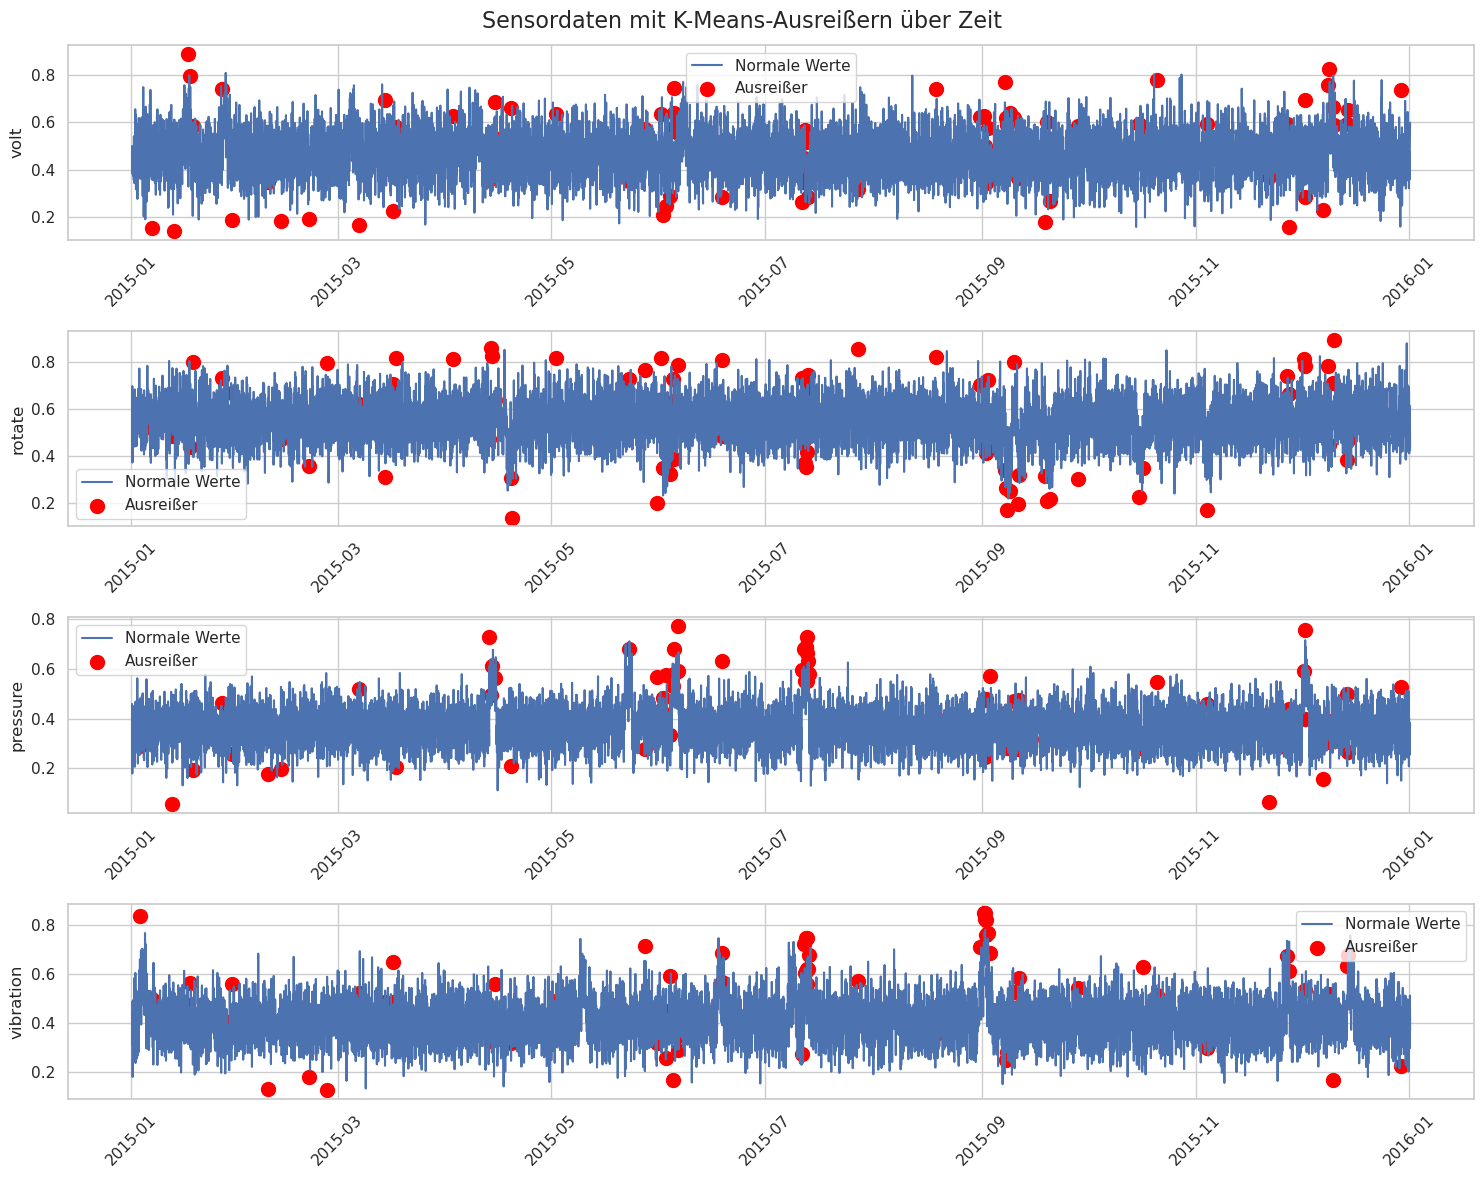

In [32]:
# Konvertiert X in ein Array für die Cluster-Berechnung
X_array = X.values

# K-Means Cluster erstellen
n_clusters = 5  # Anzahl der Cluster, kann angepasst werden
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Berechnet die Cluster-Zentren
cluster_centers = kmeans.cluster_centers_

# Berechnet die Abstände zum nächstgelegenen Clusterzentrum
distances = np.min(np.linalg.norm(X_array[:, np.newaxis] - cluster_centers, axis=2), axis=1)

# Definiert Ausreißer: Punkte, deren Abstand zu einem Clusterzentrum eine Schwelle überschreiten
threshold = np.percentile(distances, 99)  # z.B. die obersten 1% der Abstände
outliers = df_machine_1[distances > threshold]
normal_points = df_machine_1[distances <= threshold]

# Erstellt mehrere Subplots für jeden Sensor
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Sensordaten mit K-Means-Ausreißern über Zeit', fontsize=16)

for idx, feature in enumerate(features):
    # Plot der normalen Punkte
    axes[idx].plot(normal_points['datetime'], normal_points[feature], 'b-', label='Normale Werte')
    
    # Plot der Ausreißer als rote Punkte
    if len(outliers) > 0:
        axes[idx].scatter(outliers['datetime'], outliers[feature], color='red', marker='o', 
                          s=100, label='Ausreißer')
    
    # Formatierung
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True)
    axes[idx].legend()
    
    # Rotiere die x-Achsen-Labels für bessere Lesbarkeit
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()

# Ausgabe der Ausreißer-Statistiken
print("\nAusreißer-Statistiken:")
print(f"Anzahl Ausreißer: {len(outliers)}")

Der K-Means-Algorithmus wird mit fünf Clustern (n_clusters = 5) initialisiert, da dies eine übliche Wahl ist, um eine erste Gruppierung der Daten zu ermöglichen. Der Algorithmus bestimmt Clusterzentren, die die repräsentativen Werte der jeweiligen Gruppen darstellen. Anschließend werden die Abstände jedes Datenpunktes zu den nächsten Clusterzentren berechnet, um die Ausreißer zu identifizieren. Als Schwellenwert für die Definition von Anomalien wird das 99. Perzentil der berechneten Abstände verwendet, um nur die extremsten Abweichungen zu markieren.

Die Ergebnisse der Anomalieerkennung mit K-Means werden ebenfalls numerisch und visuell ausgewertet. Die Analyse zeigt, dass der K-Means-Algorithmus ähnliche Ergebnisse wie DBSCAN liefert, wobei auch hier systematische Abweichungen und potenzielle Störungen im Betrieb der Maschine identifiziert werden. Insgesamt werden 88 mögliche Anomalien erkannt, die sich über den gesamten Zeitraum verteilen.

### Autoencoder

In diesem Ansatz zur Anomalieerkennung wird die Gesamtheit aller Maschinen verwendet, um ein generelles Modell für die Rekonstruktion normaler Betriebsdaten zu trainieren. Zu Beginn werden alle als normal klassifizierten Daten ausgewählt, indem Instanzen mit bekannten Fehlern, Störungen oder Ausfällen ausgeschlossen werden. Diese gefilterten Normaldaten werden genutzt, um die Trainings- und Testdaten zu generieren. Der Autoencoder, ein neuronales Netzwerk mit Encoder-Decoder-Architektur, wird anschließend auf diesen Daten trainiert. Der Encoder komprimiert die Eingabedaten auf eine niedrigere Dimension, während der Decoder versucht, die ursprünglichen Eingabedaten aus dieser komprimierten Darstellung zu rekonstruieren. Ziel ist es, den Rekonstruktionsfehler zwischen den Originaldaten und den rekonstruierten Daten zu minimieren, was durch die Optimierung der mittleren quadratischen Fehler (Mean Squared Error, MSE) erreicht wird.

Epoch 1/5


2024-12-09 12:50:13.606871: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


21758/21758 [==============================] - 13s 568us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 2/5
21758/21758 [==============================] - 12s 545us/step - loss: 0.0047 - val_loss: 0.0047
Epoch 3/5
21758/21758 [==============================] - 12s 567us/step - loss: 0.0047 - val_loss: 0.0047
Epoch 4/5
21758/21758 [==============================] - 12s 565us/step - loss: 0.0047 - val_loss: 0.0047
Epoch 5/5
5440/5440 [==============================] - 2s 372us/step
Anomalien erkannt: 8704


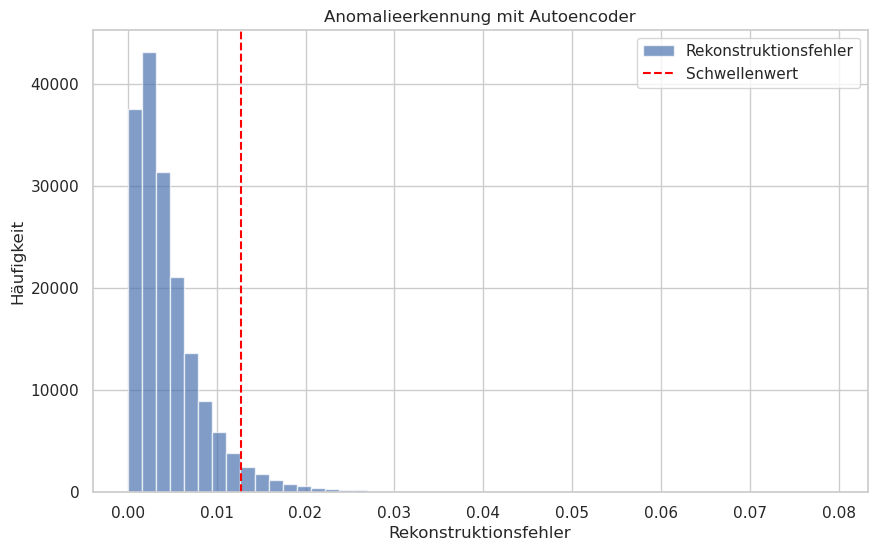

In [33]:
# Filtert die normalen Daten, bei denen errorID, failure und comp alle 0 sind
normal_data = df[(df["errorID"] == 0) & (df["failure"] == 0) & (df["comp"] == 0)]

# Entfernt nicht benötigte Spalten aus den normalen Daten
normal_data = normal_data.drop(["datetime", "machineID", "errorID", "failure", "comp", "model"], axis=1)

# Teilt die Daten in Trainings- und Testdaten auf (80% Training, 20% Test)
X_train, X_test = train_test_split(normal_data, test_size=0.2, random_state=42)

# Definiert die Dimensionen des Autoencoder-Modells
input_dim = X_train.shape[1]
encoding_dim = 5  # Anzahl der Neuronen im versteckten Layer

# Definiert das Autoencoder-Modell
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

# Erstellt das Autoencoder-Modell und kompiliert es
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Trainiert das Autoencoder-Modell
history = autoencoder.fit(X_train, X_train, 
                          epochs=5, 
                          batch_size=32, 
                          validation_data=(X_test, X_test),
                          verbose=1)

# Berechnet die Rekonstruktionsfehler für die Testdaten
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Legt den Schwellenwert für Anomalien fest (z.B. 95. Perzentil des Fehlers)
threshold = np.percentile(mse, 95)

# Ermittelt die Anomalien basierend auf dem Schwellenwert
anomalies = mse > threshold
print(f"Anomalien erkannt: {np.sum(anomalies)}")

# Visualisiert die Verteilung der Rekonstruktionsfehler und den Schwellenwert
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.7, label="Rekonstruktionsfehler")
plt.axvline(threshold, color="red", linestyle="--", label="Schwellenwert")
plt.xlabel("Rekonstruktionsfehler")
plt.ylabel("Häufigkeit")
plt.legend()
plt.title("Anomalieerkennung mit Autoencoder")
plt.show()

Das Modell wird über fünf Epochen trainiert, wobei die Verlustwerte während des Trainingsprozesses kontinuierlich sinken und sich schließlich stabilisieren. Nach dem Training wird der Rekonstruktionsfehler für die Testdaten berechnet. Ein Schwellenwert, basierend auf dem 95. Perzentil der Rekonstruktionsfehler, wird definiert, um Anomalien von normalen Daten zu unterscheiden. Datenpunkte, deren Rekonstruktionsfehler diesen Schwellenwert überschreiten, werden als Anomalien klassifiziert.

Die Verteilung der Rekonstruktionsfehler wird in einem Histogramm visualisiert, wobei der Schwellenwert durch eine rote Linie markiert ist. Die Analyse zeigt, dass etwa 8704 Datenpunkte als Anomalien erkannt werden, was dem festgelegten Schwellenwert von 95 % entspricht. Diese Anomalien spiegeln Abweichungen von den gelernten Normalmustern wider und bieten wichtige Hinweise auf potenzielle Betriebsstörungen.

### SOM mit Quantisierungsfehler

Die Anomalieerkennung mit Self-Organizing Maps (SOM) basiert auf der Berechnung von Quantisierungsfehlern und stellt eine effektive Methode dar, um komplexe Muster in hochdimensionalen Daten zu analysieren und Abweichungen zu identifizieren. In diesem Ansatz wird SOM genutzt, um die Daten zunächst zu trainieren und anschließend die Abweichungen einzelner Datenpunkte von den zugeordneten Clusterzentren zu bestimmen.

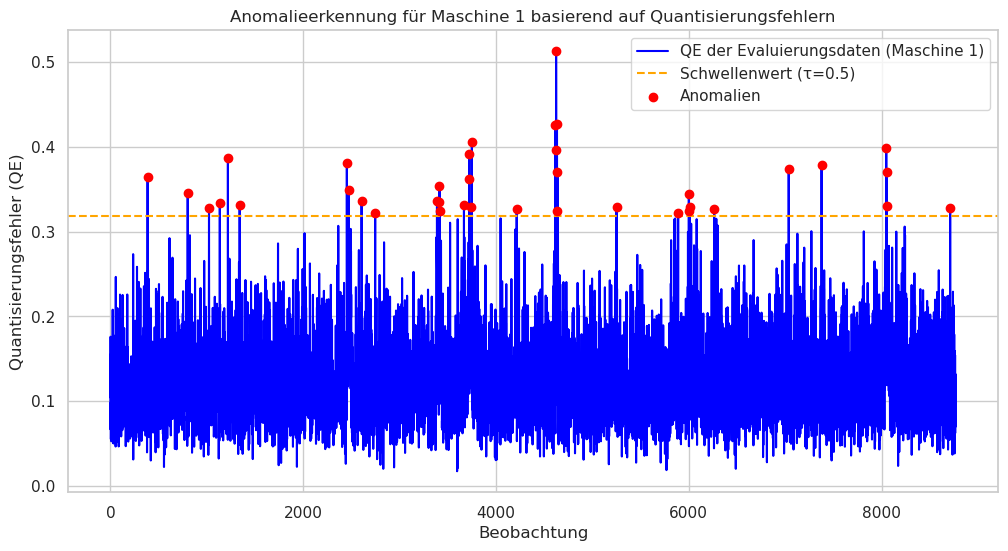

In [34]:
# Entfernt nicht benötigte Spalten und skaliert die Daten
data_scaled = df.drop(["datetime", "machineID", "errorID", "failure", "comp", "model"], axis=1)
data_scaled = data_scaled.values

# 2. Initialisiert und trainiert das Self-Organizing Map (SOM)
from minisom import MiniSom

som = MiniSom(x=10, y=10, input_len=data_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_scaled)
som.train_random(data_scaled, num_iteration=100)

# 3. Berechnet den Quantisierungsfehler
def calculate_quantization_error(som, data):
    errors = []
    for sample in data:
        winner = som.winner(sample)
        weight = som.get_weights()[winner]
        error = np.linalg.norm(sample - weight)
        errors.append(error)
    return np.array(errors)

quantization_errors = calculate_quantization_error(som, data_scaled)

# 4. Berechnet den Schwellenwert (tau)
tau = 0.5  # Justierbarer Parameter
threshold = tau * np.max(quantization_errors)

# 5. Filtert nur die Daten für Maschine 1
machine_1_data = df[df["machineID"] == 1]
machine_1_scaled = machine_1_data.drop(["datetime", "machineID", "errorID", "failure", "comp", "model"], axis=1)

# Konvertiert die Daten von Maschine 1 in numerische Werte und füllt NaN-Werte mit 0
machine_1_scaled = machine_1_scaled.apply(pd.to_numeric, errors='coerce').fillna(0).values

# Berechnet den Quantisierungsfehler für Maschine 1
machine_1_errors = calculate_quantization_error(som, machine_1_scaled)

# Identifiziert Anomalien für Maschine 1 basierend auf dem Schwellenwert
machine_1_anomalies = machine_1_errors > threshold

# 6. Visualisierung der Anomalien für Maschine 1
time_steps = range(len(machine_1_errors))  # Zeitachse für die Beobachtungen

plt.figure(figsize=(12, 6))
plt.plot(time_steps, machine_1_errors, label="QE der Evaluierungsdaten (Maschine 1)", color="blue")
plt.axhline(y=threshold, color="orange", linestyle="--", label=f"Schwellenwert (τ={tau})")
plt.scatter(
    [time_steps[i] for i in range(len(machine_1_errors)) if machine_1_anomalies[i]],
    [machine_1_errors[i] for i in range(len(machine_1_errors)) if machine_1_anomalies[i]],
    color="red",
    label="Anomalien",
    zorder=3,
)
plt.xlabel("Beobachtung")
plt.ylabel("Quantisierungsfehler (QE)")
plt.title("Anomalieerkennung für Maschine 1 basierend auf Quantisierungsfehlern")
plt.legend()
plt.grid(True)
plt.show()

Zu Beginn werden die Daten skaliert und vorbereitet, indem irrelevante Spalten wie datetime, machineID, errorID, failure, comp und model entfernt werden. Anschließend wird ein SOM mit einer zweidimensionalen Gitterstruktur (10x10) initialisiert, wobei jedes Gitterelement ein Clusterzentrum repräsentiert. Das Modell wird mit einer Lernrate von 0,5 und einem Sigma-Wert von 1,0 über 100 Iterationen trainiert, um repräsentative Gewichte für die Clusterzentren zu berechnen.

Nach dem Training wird für jeden Datenpunkt der Quantisierungsfehler berechnet. Dieser Fehler ergibt sich aus der euklidischen Distanz zwischen einem Datenpunkt und dem nächstgelegenen Clusterzentrum. Datenpunkte mit einem hohen Quantisierungsfehler weisen auf Abweichungen von den typischen Mustern hin und werden potenziell als Anomalien klassifiziert.

Um einen Schwellenwert zur Identifikation von Anomalien zu definieren, wird ein skalierbarer Parameter τ genutzt. In diesem Fall wird der Schwellenwert als 50 % des maximalen Quantisierungsfehlers definiert (τ=0.5). Nur Datenpunkte, deren Quantisierungsfehler diesen Schwellenwert überschreiten, werden als Anomalien klassifiziert.

Die Visualisierung zeigt die Quantisierungsfehler der Sensordaten für Maschine 1 über die Zeit. Der Schwellenwert wird durch eine orangefarbene Linie dargestellt, und Anomalien werden als rote Punkte hervorgehoben. Diese Darstellung verdeutlicht, dass Anomalien durch erhebliche Abweichungen von den typischen Mustern gekennzeichnet sind. Auffällige Spitzen im Quantisierungsfehler weisen darauf hin, dass zu diesen Zeitpunkten möglicherweise ungewöhnliche Betriebszustände oder potenzielle Fehler vorliegen.

### Anomalieerkennung mit Überwachtem Lernen

Bei der Anomalieerkennung mit überwachten Lernmethoden werden verfügbare Labels genutzt, um die Modelle gezielt zu trainieren. In diesem Fall beschreibt die Zielvariable failure, ob ein Fehler vorliegt (1) oder nicht (0). Obwohl die Anomalieerkennung üblicherweise ohne Labels erfolgt, ist es bei vorhandenen gelabelten Daten sinnvoll, ein überwachtes Verfahren anzuwenden. Dadurch können Muster aus den Trainingsdaten effizienter gelernt und zukünftige Anomalien präzise vorhergesagt werden.

### Identifikation des optimalen Modells

In diesem Ansatz werden überwachte Lernmethoden verwendet, um das optimale Modell zur Klassifikation von Fehlern in Sensordaten zu identifizieren. Relevante Sensorattribute wie volt, rotate, pressure und vibration werden genutzt, während die Zielvariable failure binär codiert wird. Verschiedene Modelle, darunter CatBoost, Random Forest Classifier, XGBoost, Gradient Boosting und LightGBM, werden trainiert und anhand der Metriken Genauigkeit und Kreuzvalidierung verglichen.

In [35]:
# Filtert die relevanten Features (volt, rotate, pressure, vibration) und konvertiert 'failure' in binäre Werte
train_data_anai = df[['volt', 'rotate', 'pressure', 'vibration', 'failure']]
train_data_anai['failure'] = train_data_anai['failure'].apply(lambda x: 1 if x > 0 else 0)

# Führt das Anomaly Detection (AnAI) mit verschiedenen Modellen (XGBoost, CatBoost, LightGBM, GradientBoostingClassifier, RandomForestClassifier) aus
ai1 = anai.run(target='failure', df=train_data_anai, predictor=['xgb', 'cat', 'lgbm', 'gbc', 'rfc'], ensemble=False)

Task: Classification 


░█████╗░███╗░░██╗░█████╗░██╗
██╔══██╗████╗░██║██╔══██╗██║
███████║██╔██╗██║███████║██║
██╔══██║██║╚████║██╔══██║██║
██║░░██║██║░╚███║██║░░██║██║
╚═╝░░╚═╝╚═╝░░╚══╝╚═╝░░╚═╝╚═╝
 

Started ANAI [ ✓ ]

Preprocessing Started [*]

Preprocessing Done [ ✓ ]

Training ANAI [*]

[LightGBM] [Info] Number of positive: 896, number of negative: 700871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 701767, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001277 -> initscore=-6.662139
[LightGBM] [Info] Start training from score -6.662139
[LightGBM] [Info] Number of positive: 807, number of negative: 630783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

,Name,Accuracy,Cross Validated Accuracy
0,Random Forest Classifier,99.948701,99.932741
1,CatBoost Classifier,99.885432,99.883865
2,XGBoost Classifier,99.875742,99.877167
3,Gradient Boosting Classifier,99.870043,99.868617
4,LightGBM Classifier,99.758895,99.753194



Completed ANAI Run [ ✓ ]

Saved Best Model at ('anai_info/best/classifier/models/Random_Forest_Classifier_1733749595.pkl', 'anai_info/best/classifier/scalers/Random_Forest_Classifier_Scaler_1733749595.pkl')  

Time Elapsed :  4358.21 seconds 



Der hier verwendete Ansatz nutzt das Framework anai, ein Automatisierungstool für maschinelles Lernen, das verschiedene Modelle trainiert, validiert und vergleicht. Es ermöglicht eine schnelle Auswahl des besten Modells für eine bestimmte Problemstellung, indem es sowohl klassische als auch moderne Algorithmen wie CatBoost, XGBoost, LightGBM und Random Forest Classifier automatisiert evaluiert.

Die Ergebnisse zeigen, dass Random Forest Classifier die besten Leistungen mit einer Genauigkeit von 99,49 % liefern. Diese Werte sollten jedoch mit Vorsicht betrachtet werden, da sie keine Aussage über das Gleichgewicht zwischen Präzision und Sensitivität treffen; bei der Implementierung sollte daher verstärkt auf den F1-Score geachtet werden. Aufgrund der besten Ergebnisse wird im nächsten Schritt der Random Forest Classifier trainiert, um eine robuste und präzise Fehlerklassifikation zu ermöglichen.

### Anomalieerkennung mit Random Forest Classifier

In diesem Ansatz wird ein Random Forest Classifier verwendet, um Fehler in Sensordaten zu erkennen und zu klassifizieren. Der Random Forest ist ein Ensemble-Lernverfahren, das mehrere Entscheidungsbäume kombiniert, um robuste und präzise Vorhersagen zu liefern.

In [41]:
# Bereitet die Daten vor, indem 'failure' in binäre Werte umgewandelt wird
df['failure'] = df['failure'].apply(lambda x: 1 if x > 0 else 0)

# Wählt die Features aus und trennt sie vom Ziel (failure)
features = ['volt', 'rotate', 'pressure', 'vibration', 'volt_rotate', 'pressure_vibration']
X = df[features]
y = df['failure']

# Teilt die Daten in Trainings- und Testdaten auf (80% Training, 20% Test) unter Beibehaltung der Verteilung der Zielvariable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Importiert den RandomForestClassifier und Metriken zur Modellbewertung
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Initialisiert und trainiert ein Random Forest-Modell für überwachte Klassifikation
random_forest = RandomForestClassifier(random_state=42, n_estimators=500, min_samples_split=5, max_features="sqrt", max_depth=33, bootstrap=False, n_jobs=-1)
random_forest.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
rf_predictions = random_forest.predict(X_test)

# Evaluierung der Modellleistung
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions, target_names=["Normal", "Failure"])

print(f"Random Forest Accuracy: {rf_accuracy}")
print(rf_classification_report)

# Wendet SMOTE an, um die Daten bei einem Ungleichgewicht der Klassen auszugleichen
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Trainiert das Random Forest-Modell erneut mit den ausgewogenen Trainingsdaten
random_forest = RandomForestClassifier(random_state=42, n_estimators=500, min_samples_split=5, max_features="sqrt", max_depth=33, bootstrap=False, n_jobs=-1)
random_forest.fit(X_train_balanced, y_train_balanced)

# Vorhersagen auf den Testdaten mit dem ausgewogenen Modell
rf_predictions = random_forest.predict(X_test)

# Evaluierung des Modells nach Anwendung von SMOTE
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions, target_names=["Normal", "Failure"])

print(f"Random Forest Accuracy (mit SMOTE): {rf_accuracy}")
print(rf_classification_report)

Random Forest Accuracy: 0.9994414108366297
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    175218
     Failure       1.00      0.56      0.72       224

    accuracy                           1.00    175442
   macro avg       1.00      0.78      0.86    175442
weighted avg       1.00      1.00      1.00    175442

Random Forest Accuracy (mit SMOTE): 0.9961810740871627
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    175218
     Failure       0.18      0.56      0.27       224

    accuracy                           1.00    175442
   macro avg       0.59      0.78      0.64    175442
weighted avg       1.00      1.00      1.00    175442



Der Random Forest Classifier wird mit spezifischen Hyperparametern trainiert, darunter 500 Bäume (n_estimators), eine maximale Tiefe von 33 (max_depth) und eine minimale Anzahl von 5 Samples pro Split (min_samples_split). Die Hyperparameter konnten vor der Implementierung durch Grid Search und Kreuzvalidierung optimiert werden, um die bestmögliche Leistung des Modells zu erzielen. Das Modell wird auf den Trainingsdaten angepasst und anschließend auf den Testdaten validiert.

Die Ergebnisse zeigen auf den ersten Blick eine beeindruckende Gesamtgenauigkeit von 99,94 %. Die Precision, Recall und der F1-Score variieren jedoch stark zwischen den Klassen. Während die Klasse Normal (kein Fehler) fast perfekt vorhergesagt wird, ist der Recall für die Klasse Failure (Fehler) mit 56 % deutlich niedriger. Dies ist ein häufiges Problem bei Klassifikationsaufgaben mit stark unbalancierten Daten, bei denen es viele normale Zustände und nur wenige Ausreißer gibt. Aufgrund der geringen Anzahl an Fehlerfällen fehlen oft ausreichend Trainingsdaten, um die "schlechten" Zustände korrekt zu lernen.

Um diesem Problem entgegenzuwirken, kommt SMOTE (Synthetic Minority Oversampling Technique) zum Einsatz, um die Klasse Failure durch synthetische Datenpunkte künstlich zu verstärken. Nach Anwendung von SMOTE wird der Random Forest Classifier erneut trainiert und getestet. Die Ergebnisse zeigen jedoch, dass die Verwendung von SMOTE in diesem Fall keine Verbesserung bringt. Der Recall für die Fehlerklasse bleibt bei 56 %, während der F1-Score aufgrund einer stark verringerten Präzision auf 27 % sinkt. Dies deutet darauf hin, dass die synthetischen Daten keine ausreichend realistischen Muster darstellen, um die Fehlerklasse effektiv zu verstärken. Stattdessen führt SMOTE zu einer höheren Anzahl von falsch-positiven Vorhersagen, was die Gesamtleistung des Modells beeinträchtigt. In diesem Szenario erweist sich die ursprüngliche Implementierung ohne SMOTE als die bevorzugte Wahl.

## Predictive Maintenance

Nachdem die Anomalieerkennung abgeschlossen ist und ein klares Verständnis über das Verhalten und die Muster in den Sensordaten gewonnen wurde, folgt nun der nächste Schritt: die Umsetzung von Predictive Maintenance. Ziel der Predictive Maintenance ist es, zukünftige Ausfälle präzise vorherzusagen und rechtzeitig Maßnahmen zu ergreifen, bevor größere Schäden oder Produktionsausfälle eintreten.

Um zeitliche Vorhersagen im Rahmen der Predictive Maintenance zu ermöglichen, ist es notwendig, die Rohdaten so aufzubereiten, dass sie präzise Informationen über den Zustand der Maschine und den Zeitpunkt zukünftiger Wartungsbedarfe liefern. Dazu werden wichtige Merkmale extrahiert und neue Kennzahlen erstellt, die die Grundlage für die Modellierung bilden.

In [42]:
# Filtert die Daten für Maschine 1
data = df[df['machineID'] == 1]

# Konvertiert die 'datetime'-Spalte in das Datetime-Format
data['datetime'] = pd.to_datetime(data['datetime'])

# Sortiert die Daten nach 'machineID' und 'datetime'
data = data.sort_values(by=['machineID', 'datetime'])

# Erstellt eine neue Spalte 'comp_replaced', die 1 setzt, wenn 'comp' ungleich 0 ist, andernfalls 0
data['comp_replaced'] = (data['comp'] != 0).astype(int)

# Importiert NumPy für Berechnungen
import numpy as np

# Initialisiert die Spalte 'time_to_next_replacement' mit NaN
data['time_to_next_replacement'] = np.nan

# Iteriert durch jede Maschine, um die Zeit bis zum nächsten Ersatz zu berechnen
for machine in data['machineID'].unique():
    machine_data = data[data['machineID'] == machine]
    replacement_times = machine_data[machine_data['comp_replaced'] == 1]['datetime']

    if replacement_times.empty:
        continue

    replacement_times = pd.to_datetime(replacement_times)
    next_replacement = replacement_times.iloc[0]

    for idx, row in machine_data.iterrows():
        if row['datetime'] >= next_replacement:
            future_replacements = replacement_times[replacement_times > row['datetime']]
            if not future_replacements.empty:
                next_replacement = future_replacements.iloc[0]
            else:
                break  # Kein weiterer Austausch
        time_delta = (next_replacement - row['datetime']).total_seconds() / 3600  # in Stunden
        data.loc[idx, 'time_to_next_replacement'] = time_delta

# Definiert die Features für das Modell
features = ['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']

Hierbei wird für Maschine 1 ein Merkmal comp_replaced eingeführt, das Bauteilaustausche markiert. Ein zentrales neues Merkmal ist die verbleibende Zeit bis zur nächsten Wartung, das aus den historischen Austauschzeiten berechnet wird. Zusätzlich werden bestehende Betriebsmerkmale wie volt, rotate, pressure und vibration sowie deren Kombinationen verwendet, um den Zustand der Maschine detailliert zu beschreiben. Diese aufbereiteten Daten schaffen die Grundlage für Modelle, die präzise zeitliche Vorhersagen treffen und eine effiziente Wartungsplanung ermöglichen.

### Darstellung der Verbleibenden Lebensdauer der Maschine 1

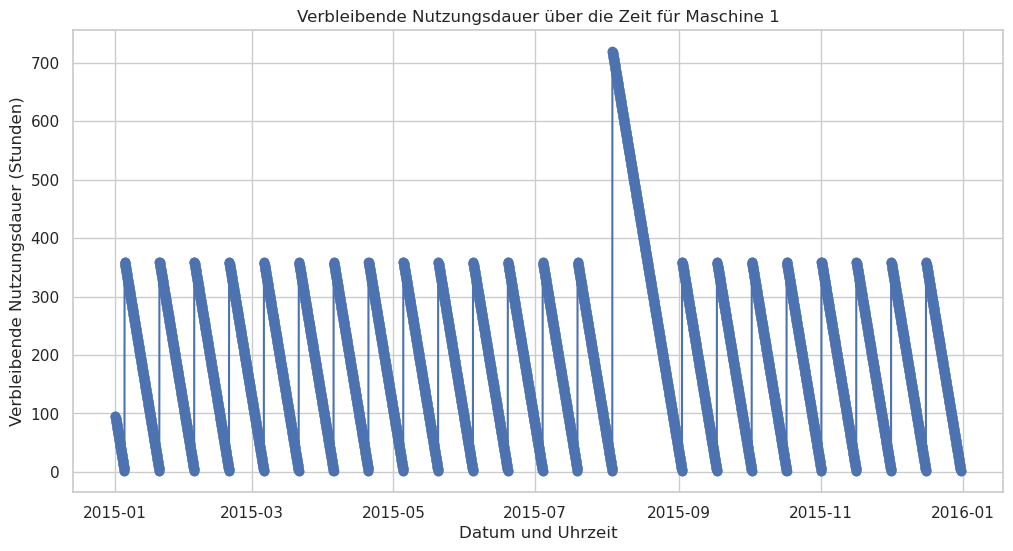

In [43]:
# Erstellt ein Plot mit einer Größe von 12x6 Zoll
plt.figure(figsize=(12,6))

# Plottet die verbleibende Nutzungsdauer ('time_to_next_replacement') über die Zeit ('datetime')
plt.plot(data['datetime'], data['time_to_next_replacement'], marker='o')

# Fügt Titel, Achsenbeschriftungen und Gitterlinien hinzu
plt.title(f'Verbleibende Nutzungsdauer über die Zeit für Maschine {1}')
plt.xlabel('Datum und Uhrzeit')
plt.ylabel('Verbleibende Nutzungsdauer (Stunden)')
plt.grid(True)

# Zeigt das Diagramm an
plt.show()

Die Grafik zeigt die verbleibende Nutzungsdauer von Maschine 1 über die Zeit. Es ist ersichtlich, dass die Werte aufgrund der verwendeten synthetischen Daten ein stark wiederholendes Muster aufweisen, wobei die verbleibende Lebensdauer zwischen den Wartungsintervallen nahezu konstant abnimmt und nach einem Bauteilaustausch wieder auf einen ähnlichen Ausgangswert zurückspringt. Dieses Verhalten spiegelt die regelmäßigen Austauschintervalle wider, die in den synthetischen Daten definiert wurden, und weist darauf hin, dass die zugrunde liegenden Daten weniger Variabilität aufweisen als in realen Anwendungsszenarien erwartet wird.

### Random Forest Regressor zur Remaining Useful Life (RUL) Vorhersage

Der Random Forest Regressor wird in diesem Ansatz verwendet, um die verbleibende Nutzungsdauer von Maschine 1 vorherzusagen. Diese Wahl basiert auf den zuvor guten Ergebnissen des Random Forest in Klassifikationsaufgaben, da dieses Modell in der Lage ist, komplexe Zusammenhänge zwischen den Variablen effektiv zu lernen. Ziel ist es, präzise Vorhersagen darüber zu treffen, wann der nächste Austausch eines Bauteils erforderlich sein wird, um die Wartungsplanung zu optimieren.

In [45]:
# Lädt das gespeicherte Scaler-Objekt
scaler = joblib.load('data/scaler.pkl')

# Setzt NaN-Werte in der Zielvariable 'time_to_next_replacement' auf -1 (außer für die letzten Zeilen)
data['time_to_next_replacement'].fillna(-1, inplace=True)

# Definiert das Ziel (y) und die Merkmale (X) für das Modell
y = data['time_to_next_replacement']
X_clean = data[features]  # Verwendet die Features wie zuvor definiert

# Teilt die Daten in Trainings- und Testsets auf (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Initialisiert und trainiert ein RandomForestRegressor-Modell
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Macht Vorhersagen auf den Testdaten
y_pred = model.predict(X_test)

# Berechnet den Mean Absolute Error (MAE) und Root Mean Squared Error (RMSE)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Gibt die Ergebnisse aus
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 104.23143019943018
Root Mean Squared Error (RMSE): 126.56421145353335


Nach dem Training des Random Forest Regressors mit 100 Entscheidungsbäumen zeigen die Ergebnisse eine Mean Absolute Error (MAE) von 104,23 Stunden und eine Root Mean Squared Error (RMSE) von 126,56 Stunden. Die Ergebnisse zeigen auch, dass die Vorhersage der verbleibenden Nutzungsdauer herausfordernd bleibt, insbesondere bei den verwendeten synthetischen Daten mit begrenzter Variabilität. Trotz der vorhandenen Abweichungen ermöglicht das Modell dennoch eine grobe Abschätzung der verbleibenden Nutzungsdauer. Diese Vorhersagen bieten die Möglichkeit, frühzeitig auf potenziellen Wartungsbedarf zu reagieren und ungeplante Ausfälle zu vermeiden.

### Beispielvorhersage der Remaining Useful Life (RUL)

Das trainierte Modell wird nun verwendet, um die verbleibende Nutzungsdauer (Remaining Useful Life, RUL) eines Bauteils auf Basis aktueller Sensordaten vorherzusagen. Dieses Beispiel illustriert, wie Sensordaten in Echtzeit verarbeitet und für Vorhersagen genutzt werden können.

In [46]:
# Beispielhafte Sensordaten
current_data = pd.DataFrame({
    'volt': [170.0],
    'rotate': [420.0],
    'pressure': [100.0],
    'vibration': [40.0],
    'age': [18]
})

# Berechnet die Zusatzmerkmale 'volt_rotate' und 'pressure_vibration'
current_data['volt_rotate'] = current_data['volt'] * current_data['rotate']
current_data['pressure_vibration'] = current_data['pressure'] * current_data['vibration']

# Wendet die gleichen Vorverarbeitungsschritte wie beim Training auf die neuen Daten an (Skalierung)
X_current = scaler.transform(current_data)

# Vorhersage der verbleibenden Nutzungsdauer (Remaining Useful Life, RUL)
rul_prediction = model.predict(X_current)

# Gibt die vorhergesagte verbleibende Nutzungsdauer aus
print(f'Vorhergesagte verbleibende Nutzungsdauer: {rul_prediction[0]:.2f} Stunden')

Vorhergesagte verbleibende Nutzungsdauer: 221.53 Stunden


Ein beispielhafter Datenpunkt repräsentiert die aktuellen Werte der Sensoren, wie Spannung, Rotationsgeschwindigkeit, Druck , Vibration und die Betriebsdauer der Maschine. Zusätzlich werden abgeleitete Merkmale wie dsa Produkt aus Spannung und Rotationsgeschwindigkeit und das Produkt aus Druck und Vibration berechnet, um die gleichen Vorverarbeitungsschritte wie im Training anzuwenden. Die Sensordaten werden mit dem gleichen Scaler transformiert, der während des Trainings verwendet wurde, um sicherzustellen, dass die Daten im gleichen Wertebereich wie die Trainingsdaten liegen. Anschließend wird der transformierte Datenpunkt dem trainierten Random Forest Regressor übergeben, der die verbleibende Nutzungsdauer vorhersagt. In diesem Beispiel ergibt die Vorhersage eine verbleibende Nutzungsdauer von 221,53 Stunden.

### Remaining Use Life mit linearer Regression

Als Alternative zu komplexen Modellen kann eine einfache lineare Funktion aufgestellt werden, um die verbleibende Nutzungsdauer (Remaining Useful Life, RUL) vorherzusagen. Diese Methode ermöglicht eine schnelle und leicht interpretierbare Analyse der Zusammenhänge zwischen den Eingabevariablen und der Zielgröße.

In [47]:
# Definiert die Merkmale (X) und das Ziel (y) für das Modell
X = data[['volt', 'rotate', 'pressure', 'vibration', 'age']]
y = data['time_to_next_replacement']

# Teilt die Daten in Trainings- und Testdaten auf (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialisiert und trainiert ein lineares Regressionsmodell
model = LinearRegression()
model.fit(X_train, y_train)

# Macht Vorhersagen auf den Testdaten
y_pred = model.predict(X_test)

# Gibt die Funktionsgleichung der linearen Regression aus
print(f'Funktion: y = {model.coef_[0]:.2f}*volt + {model.coef_[1]:.2f}*rotate + {model.coef_[2]:.2f}*pressure + {model.coef_[3]:.2f}*vibration + {model.coef_[4]:.2f}*age + {model.intercept_:.2f}')

Funktion: y = -19.74*volt + 25.37*rotate + 62.02*pressure + -59.05*vibration + -109.25*age + 289.36


Diese Gleichung zeigt die Gewichtung der einzelnen Merkmale für die Vorhersage der verbleibenden Nutzungsdauer. Beispielsweise reduziert ein höheres Maschinenalter (age) die RUL erheblich, was durch den negativen Koeffizienten von -109,25 deutlich wird. Andererseits trägt ein höherer Druck (pressure) mit einem positiven Koeffizienten von 62,02 zu einer längeren Nutzungsdauer bei. 

Es ist jedoch wichtig zu beachten, dass die lineare Funktion immer nur für einen spezifischen Zeitpunkt oder Messwert berechnet wird. Die Vorhersage spiegelt daher lediglich die verbleibende Nutzungsdauer basierend auf dem aktuellen Zustand der Maschine wider. Dieser Momentaufnahme-Ansatz erfordert bei der Interpretation Vorsicht, da dynamische oder schleichende Änderungen im Maschinenzustand nicht berücksichtigt werden. Die Funktion liefert somit keine langfristige Prognose, sondern eher eine Einschätzung auf Basis der aktuellen Betriebsbedingungen.

### Verbleibende Lebensdauer in Bezug auf die Features

Die Diagramme zeigen den Zusammenhang zwischen der verbleibenden Nutzungsdauer und den verschiedenen Sensorwerten (volt, rotate, pressure, vibration).

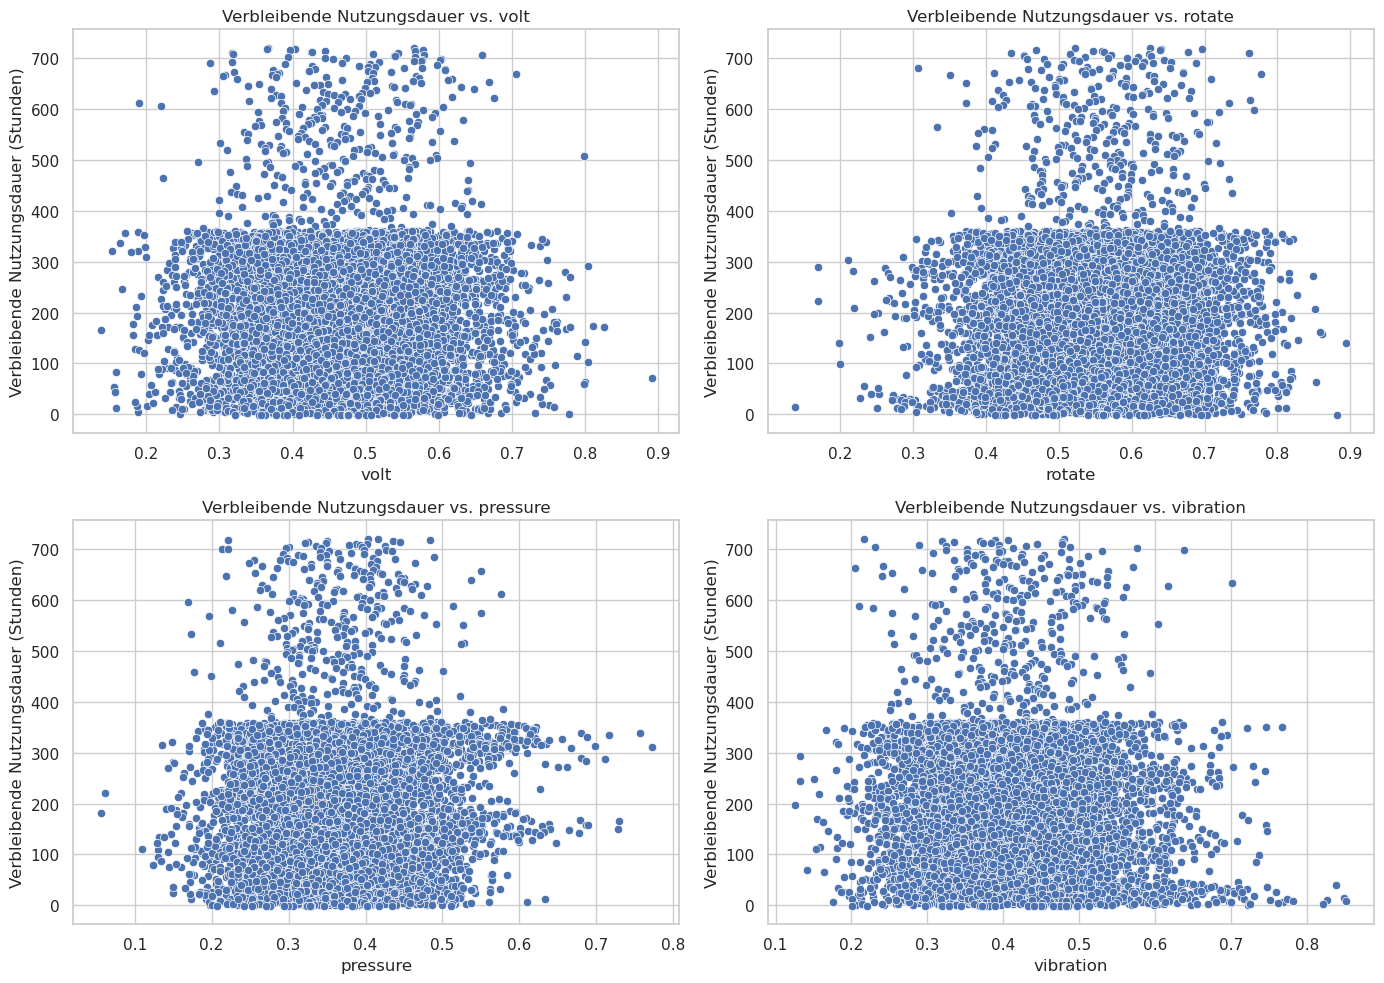

In [48]:
# Definiert die Features für die Visualisierung
features = ['volt', 'rotate', 'pressure', 'vibration']

# Erstellt ein 2x2 Subplot für die Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plottet für jedes Feature die verbleibende Nutzungsdauer vs. das jeweilige Feature
for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y='time_to_next_replacement', data=data, ax=axes[i])
    axes[i].set_title(f'Verbleibende Nutzungsdauer vs. {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Verbleibende Nutzungsdauer (Stunden)')

# Optimiert das Layout und zeigt die Diagramme an
plt.tight_layout()
plt.show()

Es fällt auf, dass die Datenpunkte bei geringerer verbleibender Nutzungsdauer deutlich stärker schwanken. Dies äußert sich in einer breiten Streuung der Werte, während die Verteilung bei höherer Nutzungsdauer schmaler wird. Das Muster der Daten zeigt eine leiche charakteristische Dreiecksform, bei der die Streuung der Punkte unten breit ist und sich mit zunehmender verbleibender Lebensdauer verengt. Diese Form deutet darauf hin, dass die Vorhersagegenauigkeit oder die Konsistenz der Sensorwerte mit abnehmender Nutzungsdauer abnimmt, da Maschinenzustände gegen Ende ihrer Lebensdauer variabler sind. Bei höherer Lebensdauer hingegen bleibt die Verteilung stabiler und enger, was auf konsistentere Betriebsbedingungen hinweist.

### Violinplot der verbleibenden Lebensdauer in Bezug auf die Fehlerklasse

Der Violinplot zeigt die Verteilung der verbleibenden Nutzungsdauer in Bezug auf verschiedene Fehlerklassen. Die Fehlerklassen umfassen hier die Codes 1 bis 4. Jede Violine repräsentiert die Verteilung der verbleibenden Nutzungsdauer für eine bestimmte Fehlerklasse und gibt sowohl die Dichte der Werte als auch deren Streuung wieder.

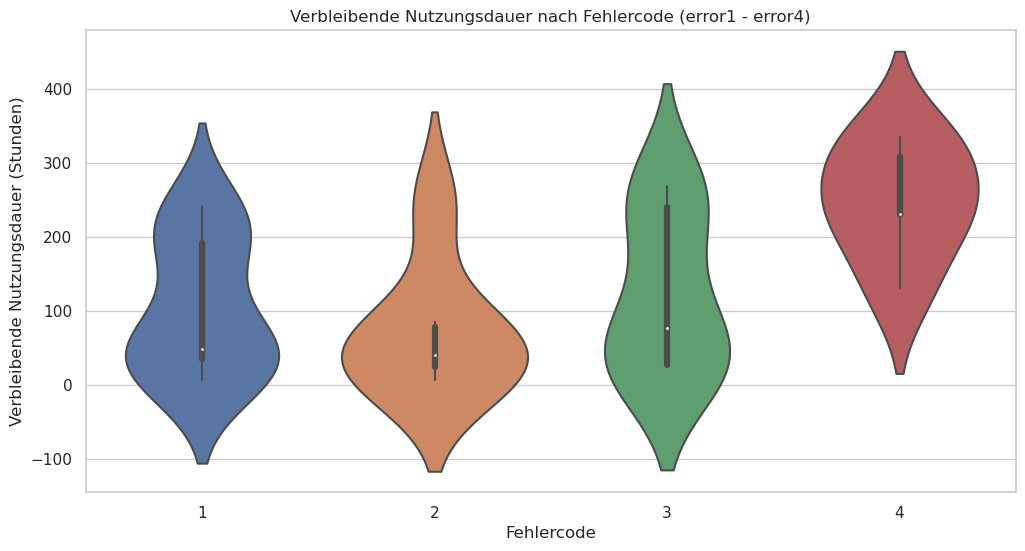

In [49]:
# Filtert die Daten für die Fehlercodes 1 bis 4 in der Spalte 'errorID'
filtered_data = data[data['errorID'].isin([1, 2, 3, 4])]

# Erstellt ein Violinplot für die verbleibende Nutzungsdauer nach Fehlercode
plt.figure(figsize=(12,6))
sns.violinplot(x='errorID', y='time_to_next_replacement', data=filtered_data)

# Fügt Titel und Achsenbeschriftungen hinzu
plt.title('Verbleibende Nutzungsdauer nach Fehlercode (error1 - error4)')
plt.xlabel('Fehlercode')
plt.ylabel('Verbleibende Nutzungsdauer (Stunden)')

# Zeigt das Diagramm an
plt.show()

Die Visualisierung macht deutlich, dass die Verteilung der verbleibenden Nutzungsdauer zwischen den Fehlerklassen variiert. Für die Fehlerklassen 2 und 3 zeigt sich beispielsweise eine stärkere Konzentration im unteren Bereich der verbleibenden Lebensdauer, was darauf hinweist, dass diese Fehler typischerweise kurz vor einem Bauteilaustausch auftreten. Im Gegensatz dazu zeigen die Fehlerklassen 1 und 4 eine größere Variabilität, was bedeutet, dass sie sowohl bei längerer als auch bei kürzerer verbleibender Lebensdauer auftreten können. Ein bemerkenswertes Ergebnis ist die Verteilung der verbleibenden Nutzungsdauer für Fehlercode 4. Im Vergleich zu den anderen Fehlerklassen zeigt Fehlercode 4 eine deutlich höhere Position in der Verteilung. Das bedeutet, dass Fehlercode 4 nicht ausschließlich in der Endphase der Lebensdauer auftritt, sondern auch bei Maschinenzuständen beobachtet wird, die noch weit vom Ausfall entfernt sind.

### Schwellenwerte aufstellen um Fehler vorherzusagen (10 % - Schwelle)

Im Rahmen der Predictive Maintenance werden Schwellenwerte definiert, um mögliche Fehlerzustände frühzeitig zu identifizieren. Diese Schwellenwerte basieren auf einer 10%-Abweichung von den durchschnittlichen Betriebswerten und ermöglichen die Identifikation von möglichen Extremwerten, die auf potenzielle Probleme hinweisen könnten.

In [50]:
# Wendet den Inverse-Scaler auf die ausgewählten Spalten an, um die skalierten Werte zurückzuwandeln
columns_to_analyze = ['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']
data_inversive = scaler.inverse_transform(data[columns_to_analyze])

# Wandelt die zurücktransformierten Werte in einen DataFrame um
data_inversive_df = pd.DataFrame(data_inversive, columns=columns_to_analyze)
data_inversive_df['datetime'] = data['datetime'].values  # Fügt die Datetime-Spalte hinzu

# Konvertiert 'datetime' in das richtige Datumsformat
data_inversive_df['datetime'] = pd.to_datetime(data_inversive_df['datetime'])

# Aggregiert die Daten täglich, indem der Mittelwert pro Tag berechnet wird
daily_aggregated = data_inversive_df.groupby(data_inversive_df['datetime'].dt.date)[columns_to_analyze].mean()

# Berechnet die Mittelwerte und Schwellenwerte
mean_values = daily_aggregated.mean()
inverse_upper_thresholds = mean_values + (0.1 * mean_values)  # Oberer Schwellenwert (10% über dem Mittelwert)
inverse_lower_thresholds = mean_values - (0.1 * mean_values)  # Unterer Schwellenwert (10% unter dem Mittelwert)

Um die Analyse zu vereinfachen und das Rauschen in den Daten zu reduzieren, werden die Werte anschließend auf Tagesebene aggregiert. Der tägliche Mittelwert der Variablen wird berechnet, um die typischen Betriebsbedingungen der Maschine zu repräsentieren. Basierend auf diesen aggregierten Mittelwerten werden obere und untere Schwellenwerte definiert. Die obere Schwelle entspricht dem Mittelwert plus 10 % des Mittelwerts, während die untere Schwelle durch den Mittelwert minus 10 % des Mittelwerts definiert wird.

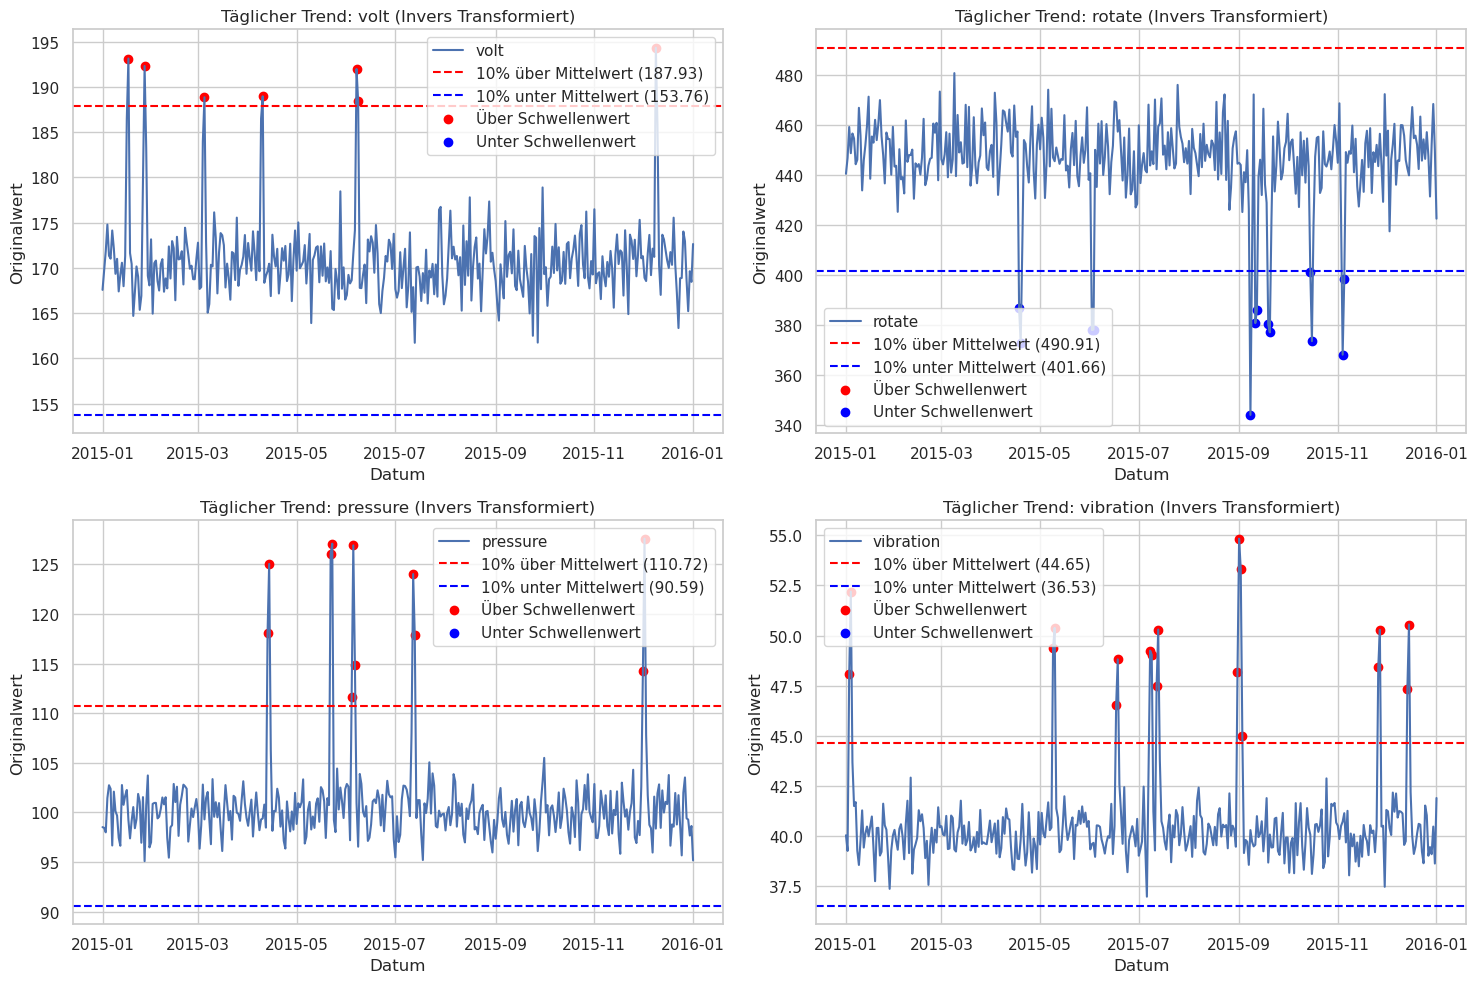

In [51]:
# Erstellt ein 2x2 Subplot mit einer Größe von 15x10 Zoll für die Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plottet die täglichen Trends für jedes Feature mit Schwellenwerten
for ax, (col, lower_threshold, upper_threshold) in zip(
    axes.flat, 
    zip(daily_aggregated.columns, inverse_lower_thresholds, inverse_upper_thresholds)
):
    # Plottet den täglichen Trend für jedes Feature
    daily_aggregated.plot(y=col, ax=ax, title=f"Täglicher Trend: {col} (Invers Transformiert)", legend=False)
    
    # Fügt horizontale Linien für die Schwellenwerte hinzu
    ax.axhline(upper_threshold, color='red', linestyle='--', label=f"10% über Mittelwert ({upper_threshold:.2f})")
    ax.axhline(lower_threshold, color='blue', linestyle='--', label=f"10% unter Mittelwert ({lower_threshold:.2f})")
    
    # Markiert die Datenpunkte, die über oder unter den Schwellenwerten liegen
    above_threshold = daily_aggregated[daily_aggregated[col] > upper_threshold]
    below_threshold = daily_aggregated[daily_aggregated[col] < lower_threshold]
    ax.scatter(above_threshold.index, above_threshold[col], color='red', label='Über Schwellenwert')
    ax.scatter(below_threshold.index, below_threshold[col], color='blue', label='Unter Schwellenwert')
    
    # Fügt eine Legende hinzu
    ax.legend()

# Setzt Achsentitel und Gitterlinien
for ax in axes.flat:
    ax.set_xlabel("Datum")
    ax.set_ylabel("Originalwert")
    ax.grid(True)

# Optimiert das Layout und zeigt das Diagramm an
plt.tight_layout()
plt.show()

Die Visualisierung zeigt den täglichen Trend der Sensorvariablen volt, rotate, pressure und vibration mit Schwellenwerten, die 10 % über und unter dem Mittelwert liegen. Hervorgehobene Punkte markieren Abweichungen: rote Punkte zeigen Werte über der oberen Schwelle, blaue Punkte solche unter der unteren Schwelle. Beispielsweise treten bei volt häufig Spannungsspitzen auf, während bei rotate wiederholt niedrige Werte auftreten, die auf mögliche mechanische Probleme hinweisen. Ähnlich deuten hohe Druck- und Vibrationswerte auf Belastungen oder Instabilitäten hin.

Die Anwendung von Schwellenwerten ist besonders für Predictive Maintenance geeignet, da sie ohne tiefgehendes Expertenwissen auskommt. Anstatt komplexe Maschinenkenntnisse zu benötigen, wird einfach beobachtet, wann Sensorwerte extrem von ihren Durchschnittswerten abweichen, indem sie die definierten Schwellenwerte (10 % über oder unter dem Mittelwert) überschreiten. Diese einfache und intuitive Methode ermöglicht es, frühzeitig potenzielle Probleme zu erkennen und Wartungsmaßnahmen rechtzeitig zu planen, ohne dass detaillierte Kenntnisse über die spezifischen Maschinenprozesse erforderlich sind.

### Evaluierung der Qualität durch Aufstellen von Schwellenwerte

Im nächsten Schritt wird geprüft, ob die durch das Überschreiten der Schwellenwerte identifizierten potenziellen Ausfälle tatsächlich mit einem Fehlercode verknüpft sind, also an den jeweiligen Tagen ein tatsächlicher Ausfall aufgetreten ist. Dabei werden die entsprechenden Sensordaten mit den Fehlercodes abgeglichen, um die Qualität der Schwellenwertmethode zu evaluieren.

In [52]:
# Mapping der Fehlercodes auf die entsprechenden Bezeichner
comp_mapping = {1: 'comp1', 2: 'comp2', 3: 'comp3', 4: 'comp4'}

# Prüft auf Datenpunkte, die die invers transformierten Grenzwerte überschreiten
for col, lower_threshold, upper_threshold in zip(
    daily_aggregated.columns, inverse_lower_thresholds, inverse_upper_thresholds
):
    error_data = data_inversive_df[
        (data_inversive_df[col] < lower_threshold) | (data_inversive_df[col] > upper_threshold)
    ]
    if not error_data.empty:
        print(f"Fehlerhafte Datenpunkte für '{col}':")
        display(error_data.head(5))  # Zeigt nur die ersten 5 Zeilen der fehlerhaften Daten
        print("\n")

# Prüft, ob Fehlercodes vorliegen (wenn 'failure' != 0) und zeigt die betroffenen Werte an
error_data_failure = data[
    (data['volt'] < inverse_lower_thresholds['volt']) | 
    (data['volt'] > inverse_upper_thresholds['volt']) |
    (data['rotate'] < inverse_lower_thresholds['rotate']) | 
    (data['rotate'] > inverse_upper_thresholds['rotate']) |
    (data['pressure'] < inverse_lower_thresholds['pressure']) | 
    (data['pressure'] > inverse_upper_thresholds['pressure']) |
    (data['vibration'] < inverse_lower_thresholds['vibration']) | 
    (data['vibration'] > inverse_upper_thresholds['vibration']) |
    (data['age'] < inverse_lower_thresholds['age']) |
    (data['age'] > inverse_upper_thresholds['age']) |
    (data['volt_rotate'] < inverse_lower_thresholds['volt_rotate']) |
    (data['volt_rotate'] > inverse_upper_thresholds['volt_rotate']) |
    (data['pressure_vibration'] < inverse_lower_thresholds['pressure_vibration']) |
    (data['pressure_vibration'] > inverse_upper_thresholds['pressure_vibration'])
]
error_data_failure = error_data_failure[error_data_failure['failure'] != 0]

# Rücktransformation der fehlerhaften Daten
if not error_data_failure.empty:
    inversed_error_data = pd.DataFrame(
        scaler.inverse_transform(error_data_failure[columns_to_analyze]),
        columns=columns_to_analyze,
        index=error_data_failure.index
    )
    inversed_error_data['comp'] = error_data_failure['comp'].map(comp_mapping)
    print("Fehlerhafte Datenpunkte mit Fehlercodes:")
    display(inversed_error_data.head(5))  # Zeigt nur die ersten 5 Zeilen der rücktransformierten Fehlerdaten
else:
    print("Keine fehlerhaften Datenpunkte mit Fehlercodes gefunden.")

# Evaluierung der Qualität: Überprüfung, wie viele echte Fehler mit den Schwellenwerten gefunden wurden
print("Anzahl der tatsächlichen Fehlercodes: ", len(data[data['failure'] != 0]))
print("Anzahl der Fehlercodes, die mit den Schwellenwerten gefunden wurden: ", len(error_data_failure))

Fehlerhafte Datenpunkte für 'volt':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
12,153.353492,490.672921,86.012440,44.108554,18.0,75246.405638,3793.884398,2015-01-01 18:00:00
16,151.335682,444.922656,94.247371,42.119652,18.0,67332.673754,3969.666491,2015-01-01 22:00:00
22,200.872430,403.235951,96.535487,32.516838,18.0,80998.985224,3139.028742,2015-01-02 04:00:00
24,197.363125,446.943947,114.342061,29.527665,18.0,88210.253930,3376.254012,2015-01-02 06:00:00
27,147.300678,420.610792,110.408985,34.203042,18.0,61956.254886,3776.323167,2015-01-02 09:00:00




Fehlerhafte Datenpunkte für 'rotate':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
3,162.462833,346.149335,109.248561,41.122144,18.0,56236.401704,4492.535078,2015-01-01 09:00:00
6,156.556031,499.071623,111.755684,42.753920,18.0,78132.672296,4777.993552,2015-01-01 12:00:00
8,175.324524,398.648781,110.624361,45.482287,18.0,69892.907687,5031.448899,2015-01-01 14:00:00
10,167.060981,382.483543,103.780663,42.675800,18.0,63898.075787,4428.922787,2015-01-01 16:00:00




Fehlerhafte Datenpunkte für 'pressure':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
0,176.217853,418.504078,113.077935,45.087686,18.0,73747.890142,5098.422421,2015-01-01 06:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
4,157.610021,435.376873,111.886648,25.990511,18.0,68619.758183,2907.991161,2015-01-01 10:00:00
6,156.556031,499.071623,111.755684,42.753920,18.0,78132.672296,4777.993552,2015-01-01 12:00:00
12,153.353492,490.672921,86.012440,44.108554,18.0,75246.405638,3793.884398,2015-01-01 18:00:00




Fehlerhafte Datenpunkte für 'vibration':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
0,176.217853,418.504078,113.077935,45.087686,18.0,73747.890142,5098.422421,2015-01-01 06:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
4,157.610021,435.376873,111.886648,25.990511,18.0,68619.758183,2907.991161,2015-01-01 10:00:00
5,172.504839,430.323362,95.927042,35.655017,18.0,74232.862383,3420.280334,2015-01-01 11:00:00
7,172.522781,409.624717,101.001083,35.482009,18.0,70669.595267,3583.721293,2015-01-01 13:00:00




Fehlerhafte Datenpunkte für 'volt_rotate':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
1,162.879223,402.747490,95.460525,43.413973,18.0,65599.198124,4144.320641,2015-01-01 07:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
3,162.462833,346.149335,109.248561,41.122144,18.0,56236.401704,4492.535078,2015-01-01 09:00:00
10,167.060981,382.483543,103.780663,42.675800,18.0,63898.075787,4428.922787,2015-01-01 16:00:00
14,170.335438,402.461187,93.235787,39.739883,18.0,68553.402446,3705.179239,2015-01-01 20:00:00




Fehlerhafte Datenpunkte für 'pressure_vibration':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
0,176.217853,418.504078,113.077935,45.087686,18.0,73747.890142,5098.422421,2015-01-01 06:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
4,157.610021,435.376873,111.886648,25.990511,18.0,68619.758183,2907.991161,2015-01-01 10:00:00
5,172.504839,430.323362,95.927042,35.655017,18.0,74232.862383,3420.280334,2015-01-01 11:00:00
6,156.556031,499.071623,111.755684,42.753920,18.0,78132.672296,4777.993552,2015-01-01 12:00:00




Fehlerhafte Datenpunkte mit Fehlercodes:


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,comp
96,179.303153,499.777962,111.833028,52.383097,18.0,89611.764483,5858.160304,comp4
97,179.303153,499.777962,111.833028,52.383097,18.0,89611.764483,5858.160304,comp1
1539,198.257975,456.862342,89.333995,38.671900,18.0,90576.602655,3454.715313,comp1
2620,180.050801,346.362480,105.661164,39.218055,18.0,62362.841967,4143.825299,comp2
4061,187.673963,493.005160,105.334392,53.963961,18.0,92524.232422,5684.261009,comp1


Anzahl der tatsächlichen Fehlercodes:  11
Anzahl der Fehlercodes, die mit den Schwellenwerten gefunden wurden:  11


Die Evaluierung der Qualität der Schwellenwerte zeigt, dass diese Methode effektiv zur Identifikation von Anomalien und Fehlern in den Sensordaten eingesetzt werden kann. Durch die Überprüfung, welche Datenpunkte die definierten Schwellenwerte überschreiten, lassen sich potenziell fehlerhafte Zustände identifizieren. In den vorliegenden Daten konnten insgesamt elf tatsächliche Fehlercodes identifiziert werden, die alle korrekt von den Schwellenwerten erfasst wurden. Hier wird die "Modellqualität" geprüft, indem geschaut wird, wie viele der tatächlichen Ausfälle vorhergesagt wurden. 

Die Schwellenwertmethode tendiert dazu, potenzielle Ausfälle eher frühzeitig zu markieren, was auf die konservative Festlegung der Grenzen zurückzuführen ist. Dies stellt sicher, dass Anomalien frühzeitig erkannt werden, auch wenn nicht jede Überschreitung unmittelbar zu einem Ausfall führt. Dieser vorsichtige Ansatz minimiert das Risiko ungeplanter Ausfälle und ermöglicht eine rechtzeitige Planung präventiver Maßnahmen, was aus wissenschaftlicher Sicht einen robusten und sicherheitsorientierten Ansatz darstellt.

## Diagnose

Die Diagnose spielt eine zentrale Rolle in der Predictive Maintenance, da sie nicht nur das Erkennen von Anomalien umfasst, sondern auch die Ursachenanalyse ermöglicht, um gezielt Gegenmaßnahmen einleiten zu können. In diesem Zusammenhang kommen sowohl regelbasierte (RBF) als auch fallbasierte (CBR) Ansätze zum Einsatz. Während der regelbasierte Ansatz auf vordefinierten Regeln und Bedingungen basiert, die aus Expertenwissen abgeleitet wurden, zielt der fallbasierte Ansatz darauf ab, frühere ähnliche Fälle zu nutzen, um aktuelle Zustände zu bewerten.

In diesem Kapitel liegt der Fokus speziell auf der Diagnose typischer Ursachen von Ausfällen. Um diese gezielt analysieren zu können, werden ausschließlich Daten betrachtet, bei denen tatsächliche Ausfälle dokumentiert sind. Diese Herangehensweise ermöglicht es, die zugrunde liegenden Muster und Zusammenhänge zwischen den Sensorwerten und den auftretenden Fehlern zu identifizieren, um präzise Rückschlüsse auf die Ursachen ziehen zu können.

### Regelbasiert (RBF)

Der regelbasierte Ansatz (RBF) nutzt vordefinierte Schwellenwerte, um potenzielle Anomalien in den Sensordaten zu identifizieren. In der Regel erfordert dieser Ansatz Expertenwissen, um die Schwellenwerte präzise an die spezifischen Eigenschaften der Maschine und ihrer Betriebsbedingungen anzupassen. In diesem Fall wird jedoch eine Schwelle von 10 % oberhalb und unterhalb der Mittelwerte der Sensorvariablen als konservative Herangehensweise gewählt. Diese Entscheidung basiert darauf, dass diese Schwelle in der vorherigen Analyse alle potenziellen Ausfälle korrekt identifiziert hat.

In [54]:
# Filtern der Daten, um nur die Zeilen mit Fehlern ('failure' != 0) zu behalten
data = data_raw
data = data[data['failure'] != 0]

# Rücktransformation der relevanten Spalten
data[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']] = scaler.inverse_transform(data[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']])

# Berechnung der Mittelwerte der relevanten Spalten
mean_values = data[['volt', 'rotate', 'pressure', 'vibration']].mean()

# Festlegung der Schwellenwerte basierend auf den Mittelwerten
THRESHOLDS = {
    "volt_high": mean_values['volt'] * 1.10,
    "volt_low": mean_values['volt'] * 0.90,
    "rotate_high": mean_values['rotate'] * 1.10,
    "rotate_low": mean_values['rotate'] * 0.90,
    "pressure_high": mean_values['pressure'] * 1.10,
    "pressure_low": mean_values['pressure'] * 0.90,
    "vibration_high": mean_values['vibration'] * 1.10,
    "vibration_low": mean_values['vibration'] * 0.90,
}

# Funktion zur Anwendung von Regelbasierter Diagnose (RBS) mit dynamischen Schwellenwerten
def apply_rbs_with_dynamic_thresholds(data, thresholds):
    results = []
    for _, row in data.iterrows():
        rules_triggered = []
        if row['vibration'] > thresholds['vibration_high']:
            rules_triggered.append("High Vibration")
        elif row['vibration'] < thresholds['vibration_low']:
            rules_triggered.append("Low Vibration")
        if row['pressure'] > thresholds['pressure_high']:
            rules_triggered.append("High Pressure")
        elif row['pressure'] < thresholds['pressure_low']:
            rules_triggered.append("Low Pressure")
        if row['rotate'] > thresholds['rotate_high']:
            rules_triggered.append("High Rotation Speed")
        elif row['rotate'] < thresholds['rotate_low']:
            rules_triggered.append("Low Rotation Speed")
        if row['volt'] > thresholds['volt_high']:
            rules_triggered.append("High Voltage")
        elif row['volt'] < thresholds['volt_low']:
            rules_triggered.append("Low Voltage")
        
        # Zusammenfassung der Diagnose
        results.append(", ".join(rules_triggered) if rules_triggered else "No Issues")
    
    data['RBS_Diagnosis'] = results
    return data

# Anwenden der Regelbasierten Diagnose (RBS) auf die Daten mit dynamischen Schwellenwerten
rbs_results_dynamic = apply_rbs_with_dynamic_thresholds(data, THRESHOLDS)

# Zeigt die ersten paar Zeilen mit der RBS-Diagnose an
display(rbs_results_dynamic.head())

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration,RBS_Diagnosis
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,4,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed"
97,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,1,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed"
1539,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,0,1,1,3,18.0,90576.602655,3454.715313,"Low Vibration, Low Pressure, High Voltage"
2620,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,0,2,2,3,18.0,62362.841967,4143.825299,Low Rotation Speed
4061,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,0,4,1,3,18.0,92524.232422,5684.261009,"High Vibration, High Rotation Speed"


Während der Diagnose wird jede Sensormessung mit den entsprechenden Schwellenwerten verglichen. Überschreitet ein Wert die obere Schwelle oder fällt er unter die untere, wird die entsprechende Regel ausgelöst. Die Ergebnisse der Diagnose werden in einem neuen Feld RBS_Diagnosis dokumentiert, das alle aktivierten Regeln für jeden Datensatz auflistet. Beispielsweise kann eine Diagnose wie "High Vibration, High Rotation Speed" darauf hinweisen, dass die Schwingungen und die Rotationsgeschwindigkeit gleichzeitig ungewöhnlich hoch sind.

### Fallbasiert (CBR)

Der fallbasierte Ansatz (Case-Based Reasoning, CBR) nutzt historische Fälle, um aktuelle Maschinenzustände zu bewerten und potenzielle Anomalien zu diagnostizieren. Dieser Ansatz basiert auf der Idee, dass ähnliche Probleme oft ähnliche Ursachen und Lösungen haben, wodurch bestehendes Wissen aus der Vergangenheit auf neue Situationen übertragen werden kann.

In [55]:
# Importiert die benötigten Bibliotheken für CBR und Ähnlichkeitsberechnung
from sklearn.metrics import euclidean_distances
import numpy as np

# Wählt die relevanten Features für die Ähnlichkeitsberechnung aus
FEATURES = ['volt', 'rotate', 'pressure', 'vibration']

# Definiert eine Funktion zur Berechnung der Ähnlichkeit (Euclidean Distanz hier)
def compute_similarity(case, cases):
    distances = euclidean_distances([case], cases)[0]
    return distances

# Wendet Case-Based Reasoning (CBR) an, um den ähnlichsten historischen Fall zu finden
def apply_cbr(data, features):
    case_base = data[features].values
    cbr_diagnoses = []
    for i, current_case in enumerate(case_base):
        # Vergleicht den aktuellen Fall mit allen anderen Fällen
        distances = compute_similarity(current_case, np.delete(case_base, i, axis=0))
        # Findet den ähnlichsten Fall (kleinste Distanz)
        most_similar_idx = np.argmin(distances)
        # Verwendet die Diagnose des ähnlichsten Falls (falls vorhanden)
        cbr_diagnoses.append(data.iloc[most_similar_idx]['RBS_Diagnosis'])
    data['CBR_Diagnosis'] = cbr_diagnoses
    return data

# Wendet CBR auf den Datensatz mit den RBS-Diagnosen an
cbr_results = apply_cbr(rbs_results_dynamic, FEATURES)

# Zeigt die ersten paar Zeilen mit der CBR-Diagnose an
display(cbr_results.head())

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration,RBS_Diagnosis,CBR_Diagnosis
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,4,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"
97,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,1,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"
1539,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,0,1,1,3,18.0,90576.602655,3454.715313,"Low Vibration, Low Pressure, High Voltage","Low Pressure, Low Rotation Speed"
2620,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,0,2,2,3,18.0,62362.841967,4143.825299,Low Rotation Speed,Low Vibration
4061,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,0,4,1,3,18.0,92524.232422,5684.261009,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"


Zur Diagnose werden relevante Merkmale wie volt, rotate, pressure und vibration herangezogen. Die Ähnlichkeit zwischen einem aktuellen Fall und historischen Fällen wird anhand der euklidischen Distanz berechnet, wobei der Fall mit der geringsten Distanz als der ähnlichste gilt. Die Diagnose des ähnlichsten historischen Falls wird dann auf den aktuellen Fall übertragen. In den Ergebnissen wird die Diagnose in einem neuen Feld CBR_Diagnosis gespeichert, das die aus dem Vergleich hervorgegangene Zuordnung darstellt.

Dieser Ansatz zeigt seine Stärke insbesondere bei der Wiederverwendung von zuvor durchgeführten Diagnosen. Beispielsweise wird bei einem Fall mit hoher Vibration und hoher Rotationsgeschwindigkeit die gleiche Diagnose auf einen ähnlichen Fall angewendet, wodurch konsistente Ergebnisse erzielt werden. CBR ergänzt den regelbasierten Ansatz (RBF) durch eine datengetriebene Perspektive und ermöglicht es, Muster und Zusammenhänge in historischen Daten effizient zu nutzen.

### Vergleich der Diagnoseverfahren

In [56]:
# Vergleicht die RBS- und CBR-Diagnosen
comparison_results = cbr_results[['RBS_Diagnosis', 'CBR_Diagnosis']]

# Berechnet Vergleichsmetriken
comparison_metrics = {
    "Total Cases": len(comparison_results),
    "Matching Diagnoses": (comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']).sum(),
    "Differing Diagnoses": (comparison_results['RBS_Diagnosis'] != comparison_results['CBR_Diagnosis']).sum(),
}

# Fügt eine Spalte hinzu, um Unterschiede zu markieren
comparison_results['Match'] = comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']

# Zeigt die Vergleichsergebnisse und Metriken an
display(comparison_results)
comparison_metrics

,RBS_Diagnosis,CBR_Diagnosis,Match
96,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
97,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
1539,"Low Vibration, Low Pressure, High Voltage","Low Pressure, Low Rotation Speed",False
2620,Low Rotation Speed,Low Vibration,False
4061,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
...,...,...,...
867650,"Low Vibration, High Voltage",High Voltage,False
868010,Low Voltage,Low Vibration,False
869451,"High Vibration, High Rotation Speed, High Voltage","High Rotation Speed, High Voltage",False
874494,"Low Pressure, High Rotation Speed, High Voltage","Low Vibration, Low Pressure, High Rotation Spe...",False


{'Total Cases': 1122, 'Matching Diagnoses': 825, 'Differing Diagnoses': 297}

Der Vergleich zwischen den regelbasierten (RBS) und fallbasierten (CBR) Diagnoseverfahren zeigt, wie unterschiedlich die beiden Ansätze Diagnosen generieren und welche Übereinstimmungen oder Differenzen bestehen. In der Analyse wurden insgesamt 1122 Fälle untersucht. Dabei ergaben sich 825 übereinstimmende Diagnosen, während in 297 Fällen die Diagnosen zwischen den beiden Ansätzen voneinander abwichen.

Die Übereinstimmung ist darauf zurückzuführen, dass beide Ansätze auf denselben zugrunde liegenden Sensordaten basieren und ähnliche Anomalien identifizieren. Unterschiede treten jedoch auf, da RBS deterministisch auf festen Schwellenwerten basiert, während CBR durch die Vergleichbarkeit mit historischen Fällen flexibler ist. Beispielsweise kann RBS eine Diagnose wie "High Vibration, High Rotation Speed" generieren, basierend auf vordefinierten Grenzwerten, während CBR für denselben Fall möglicherweise zusätzliche Merkmale berücksichtigt und eine Diagnose wie "High Rotation Speed, High Voltage" vorschlägt, basierend auf einem ähnlichen historischen Fall.

### Mögliche Fehlerursachen der Ausfälle darstellen

Die Visualisierung zeigt die zehn häufigsten Fehlerursachen, die durch die Diagnosemethoden RBS (regelbasiert) und CBR (fallbasiert) identifiziert wurden. Beide Verfahren bieten wertvolle Einblicke in potenzielle Probleme, wobei jede Methode unterschiedliche Schwerpunkte in der Fehleridentifikation setzen kann.

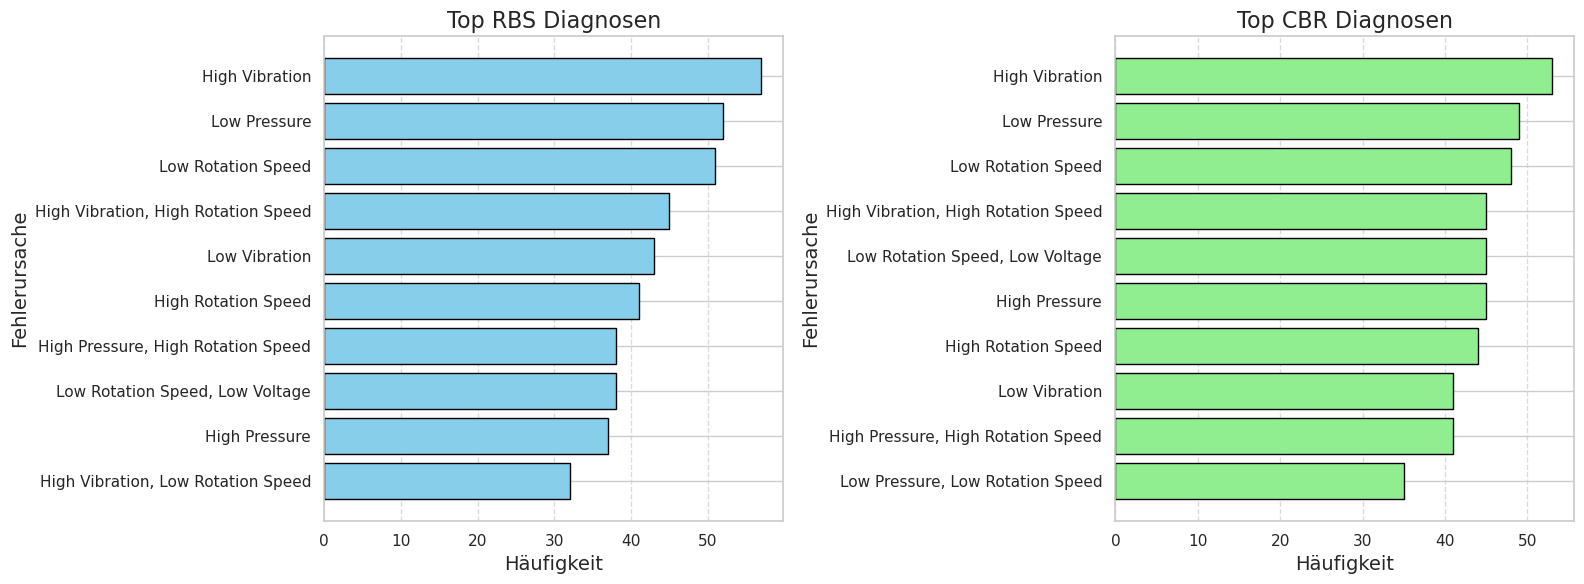

In [58]:
# Definiert eine Funktion zur Visualisierung der häufigsten Diagnosen für RBS und CBR in separaten Balkendiagrammen
def visualize_two_separate_charts(data, rbs_column='RBS_Diagnosis', cbr_column='CBR_Diagnosis', top_n=10):
    # Filtert und zählt die RBS-Diagnosen
    rbs_counts = data[(data[rbs_column].notna()) & (data[rbs_column] != 'No Issues')][rbs_column].value_counts().head(top_n)

    # Filtert und zählt die CBR-Diagnosen
    cbr_counts = data[(data[cbr_column].notna()) & (data[cbr_column] != 'No Issues')][cbr_column].value_counts().head(top_n)

    # Erstellt die Abbildung und Achsen für zwei separate Balkendiagramme
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plottet die RBS-Diagnosen
    ax1.barh(rbs_counts.index, rbs_counts.values, color='skyblue', edgecolor='black')
    ax1.set_title('Top RBS Diagnosen', fontsize=16)
    ax1.set_xlabel('Häufigkeit', fontsize=14)
    ax1.set_ylabel('Fehlerursache', fontsize=14)
    ax1.invert_yaxis()  # Umkehrung der y-Achse für bessere Lesbarkeit
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Plottet die CBR-Diagnosen
    ax2.barh(cbr_counts.index, cbr_counts.values, color='lightgreen', edgecolor='black')
    ax2.set_title('Top CBR Diagnosen', fontsize=16)
    ax2.set_xlabel('Häufigkeit', fontsize=14)
    ax2.set_ylabel('Fehlerursache', fontsize=14)
    ax2.invert_yaxis()  # Umkehrung der y-Achse für bessere Lesbarkeit
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Layout anpassen und Diagramme anzeigen
    plt.tight_layout()
    plt.show()

# Ruft die Funktion auf, um unabhängige Visualisierungen für RBS und CBR zu erstellen
visualize_two_separate_charts(rbs_results_dynamic, rbs_column='RBS_Diagnosis', cbr_column='CBR_Diagnosis')

Die Ergebnisse der Diagnose verdeutlichen, dass häufige Probleme wie „High Vibration“ und „Low Pressure“ zentrale Indikatoren für den Zustand der Maschinen darstellen. „High Vibration“ könnte dabei auf mechanische Probleme wie Unwuchten oder Lagerdefekte hinweisen, die durch erhöhte Schwingungen erkennbar werden. „Low Pressure“ hingegen deutet auf potenzielle Probleme im hydraulischen oder pneumatischen System hin, wie etwa Undichtigkeiten oder Verstopfungen. Beide Fehlerursachen gehören zu den häufigsten, da sie oft als erste Anzeichen für eine Verschlechterung der Maschinenleistung auftreten.

Die Ergebnisse zeigen auch, dass beide Verfahren komplementär genutzt werden können. Während RBS durch seine einfache Implementierung schnelle Diagnosen ermöglicht, bietet CBR eine tiefere Analyse von Mustern und Kombinationen, die mit fortschreitendem Verschleiß oder sich entwickelnden Defekten auftreten. Diese Kombination bietet nicht nur die Möglichkeit, akute Probleme zu erkennen, sondern auch langfristige Entwicklungen besser zu verstehen und präventive Maßnahmen gezielter zu planen.